<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Evaluación de redes *Feed-Forward* vı́a validación cruzada (cross-validation).
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Identificar el gradiente desvaneciente.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 26 de Octubre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea1-INF395-II-2018]

<hr style="height:2px;border:none"/>

#### Paquetes instalación

Para poder trabajar en el curso se necesitará instalar librerías para Python, por lo que se recomienda instalarlas a través de anaconda (para Windows y sistemas Unix) en un entorno virtual, donde podrán elegir su versión de Python. Se instalarán librerías como sklearn, una librería simple y de facil acceso para data science, keras en su versión con GPU (para cálculo acelerado a través de la tarjeta gráfica), además de que ésta utiliza como backend TensorFlow o Theano, por lo que habrá que instalar alguno de éstos, además de las librerías básicas de computer science como *numpy, matplotlib, pandas,* además de claramente *jupyter*.

* Descargar anacona
* Luego de instalar Anaconda y tenerla en el path de su computador crear un entorno virtual:
```
conda create -n redesneuronales python=version
```
con version, la version de Python que desea utilizar. Si está en Windows, se recomienda Python 3 debido a dependencias con una de las librerías a utilziar.

* Acceder al ambiente creado
```
source activate redesneuronales
```

* Instalar los paquetes a utilizar
```
conda install jupyter sklearn numpy pandas matplotlib keras-gpu tensorflow-gpu
```

*  Para salir del entorno
```
source deactivate redesneuronales
```

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[1.](#primero) Predicción de Entalpía de Atomización  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Entendimiento de imágenes de personas

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.layers.core import Dense, Activation
from keras.layers import Dense, Activation
from keras import backend as k
import keras as K
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.
```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
...#transform val and test
```

In [94]:
########################################################################################### a
# Se importan los datos y se trabaja con ellos

datos= pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
datos.describe()
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True) # Elimina filas con datos faltantes
print("--------------------------")
datos.info()
total=len(datos)

# Se divide en los conjuntos
df_train=datos[:int(0.6*total)]                       # 60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          # 25% de los datos
df_test=datos[int(0.85*total)::]                      # 15% restante

########################################################################################### a1
miu, sigma =0,1
scaler = StandardScaler().fit(df_train)                                                 # 
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)      # 
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)           # 
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)        # Normaliza cada conjunto
...
y_train = df_train.pop('Eat').values.reshape(-1,1)                                      # Obtiene la columna de 
y_val = df_val.pop('Eat').values.reshape(-1,1)                                          # interes (salidas)
...
X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1278 entries, Unnamed: 0 to Eat
dtypes: float64(1276), int64(2)
memory usage: 158.4 MB
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1276 entries, 0 to Eat
dtypes: float64(1276)
memory usage: 158.1 MB




> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 250 *epochs*. Comente.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
- ###calculate gradients
from keras import backend as K
import tensorflow as tf
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
```

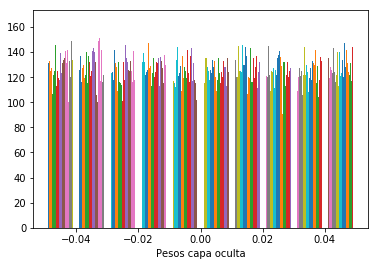

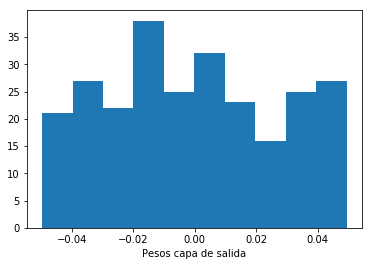

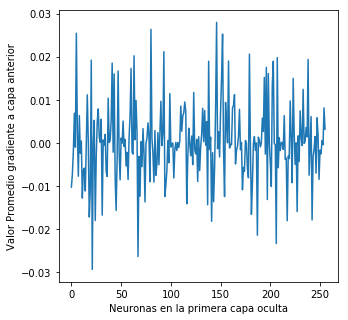

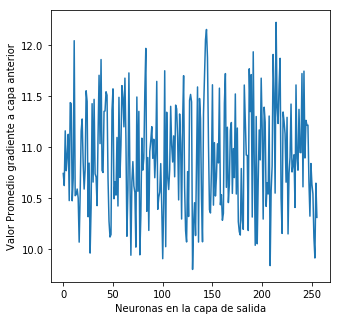

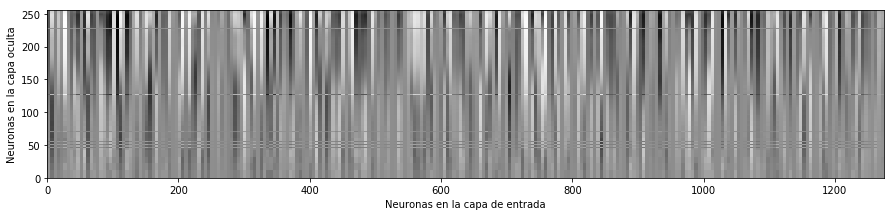

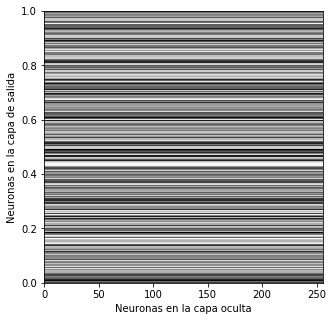

In [95]:
########################################## MODELO DE LA RED
B1_model = Sequential()
B1_model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
B1_model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
B1_sgd = SGD(lr=0.01)
B1_model.compile(optimizer=B1_sgd,loss='mean_squared_error')

########################################## CALCULO DE LOS GRADIENTES
B1_loss = K.losses.mean_squared_error(B1_model.output,y_train)
B1_listOfVariableTensors = B1_model.trainable_weights
B1_gradients = k.gradients(B1_loss, B1_listOfVariableTensors)

B1_sess = k.get_session()

B1_evaluated_gradients = B1_sess.run(B1_gradients,feed_dict={ B1_model.input:X_train_scaled.values})
B1_evaluated_gradients = [gradient/len(y_train) for gradient in B1_evaluated_gradients]

########################################## OBTENCION DE PESOS 
B1_weights0, B1_biases0 = B1_model.layers[0].get_weights()
B1_weights1, B1_biases1 = B1_model.layers[1].get_weights()

########################################## OBTENCION DE GRADIENTES
B1_grafico0=B1_evaluated_gradients[0]
B1_grafico1=B1_evaluated_gradients[2]

########################################## GRAFICADO DE PESOS
_= plt.hist(B1_weights0)
_= plt.xlabel('Pesos capa oculta')
plt.show()
_= plt.hist(B1_weights1)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(B1_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salida')
plt.plot(B1_grafico1);

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la capa oculta')
plt.imshow(B1_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(B1_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

In [96]:
########################################################################################### b
B1_history = B1_model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))


Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 10s 1ms/step - loss: 1.5953 - val_loss: 0.5286
Epoch 2/250
9745/9745 [==============================] - 4s 378us/step - loss: 0.6026 - val_loss: 0.4699
Epoch 3/250
9745/9745 [==============================] - 4s 370us/step - loss: 0.5041 - val_loss: 0.4442
Epoch 4/250
9745/9745 [==============================] - 4s 382us/step - loss: 0.4202 - val_loss: 0.3602
Epoch 5/250
9745/9745 [==============================] - 4s 375us/step - loss: 0.3610 - val_loss: 0.4099
Epoch 6/250
9745/9745 [==============================] - 4s 374us/step - loss: 0.3162 - val_loss: 0.2817
Epoch 7/250
9745/9745 [==============================] - 4s 378us/step - loss: 0.2708 - val_loss: 0.2566
Epoch 8/250
9745/9745 [==============================] - 4s 375us/step - loss: 0.2417 - val_loss: 0.2488
Epoch 9/250
9745/9745 [==============================] - 4s 371us/step - loss: 0.2149 - val_loss: 0.2218
Epoch 10

Epoch 78/250
9745/9745 [==============================] - 4s 362us/step - loss: 0.0299 - val_loss: 0.0543
Epoch 79/250
9745/9745 [==============================] - 4s 362us/step - loss: 0.0307 - val_loss: 0.0525
Epoch 80/250
9745/9745 [==============================] - 4s 364us/step - loss: 0.0307 - val_loss: 0.0500
Epoch 81/250
9745/9745 [==============================] - 4s 365us/step - loss: 0.0302 - val_loss: 0.0728
Epoch 82/250
9745/9745 [==============================] - 4s 364us/step - loss: 0.0297 - val_loss: 0.0498
Epoch 83/250
9745/9745 [==============================] - 4s 364us/step - loss: 0.0294 - val_loss: 0.0530
Epoch 84/250
9745/9745 [==============================] - 4s 364us/step - loss: 0.0290 - val_loss: 0.0468
Epoch 85/250
9745/9745 [==============================] - 4s 365us/step - loss: 0.0285 - val_loss: 0.0501
Epoch 86/250
9745/9745 [==============================] - 3s 358us/step - loss: 0.0291 - val_loss: 0.0457
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 4s 370us/step - loss: 0.0186 - val_loss: 0.0394
Epoch 156/250
9745/9745 [==============================] - 4s 370us/step - loss: 0.0193 - val_loss: 0.0387
Epoch 157/250
9745/9745 [==============================] - 4s 371us/step - loss: 0.0193 - val_loss: 0.0420
Epoch 158/250
9745/9745 [==============================] - 4s 367us/step - loss: 0.0188 - val_loss: 0.0478
Epoch 159/250
9745/9745 [==============================] - 4s 367us/step - loss: 0.0190 - val_loss: 0.0456
Epoch 160/250
9745/9745 [==============================] - 4s 369us/step - loss: 0.0195 - val_loss: 0.0376
Epoch 161/250
9745/9745 [==============================] - 4s 369us/step - loss: 0.0191 - val_loss: 0.0542
Epoch 162/250
9745/9745 [==============================] - 4s 369us/step - loss: 0.0187 - val_loss: 0.0434
Epoch 163/250
9745/9745 [==============================] - 4s 371us/step - loss: 0.0194 - val_loss: 0.0390
Epoch 164/250
9745/9745 [============

In [97]:
########################################## CALCULO DE LOS GRADIENTES
B2_loss = K.losses.mean_squared_error(B1_model.output,y_train)
B2_listOfVariableTensors = B1_model.trainable_weights
B2_gradients = k.gradients(B2_loss, B2_listOfVariableTensors)

B2_sess = k.get_session()

B2_evaluated_gradients = B2_sess.run(B2_gradients,feed_dict={ B1_model.input:X_train_scaled.values})
B2_evaluated_gradients = [gradient/len(y_train) for gradient in B2_evaluated_gradients]

########################################## OBTENCION DE PESOS 
B2_weights0, B2_biases0 = B1_model.layers[0].get_weights()
B2_weights1, B2_biases1 = B1_model.layers[1].get_weights()

########################################## OBTENCION DE GRADIENTES
B2_grafico0=B2_evaluated_gradients[0]
B2_grafico1=B2_evaluated_gradients[2]

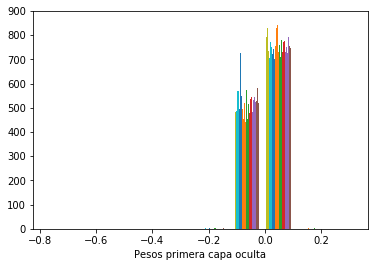

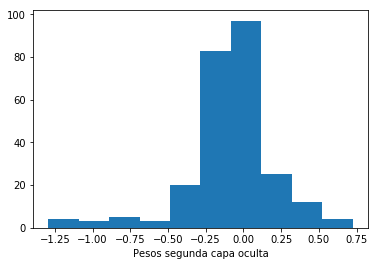

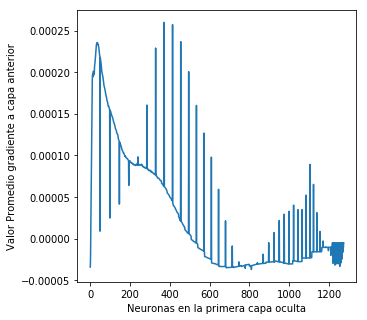

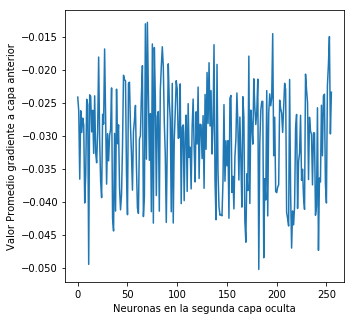

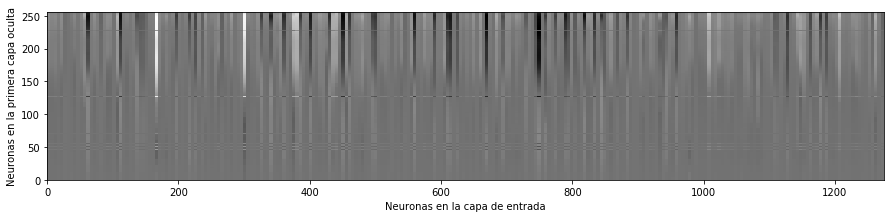

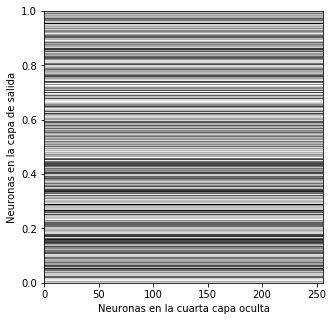

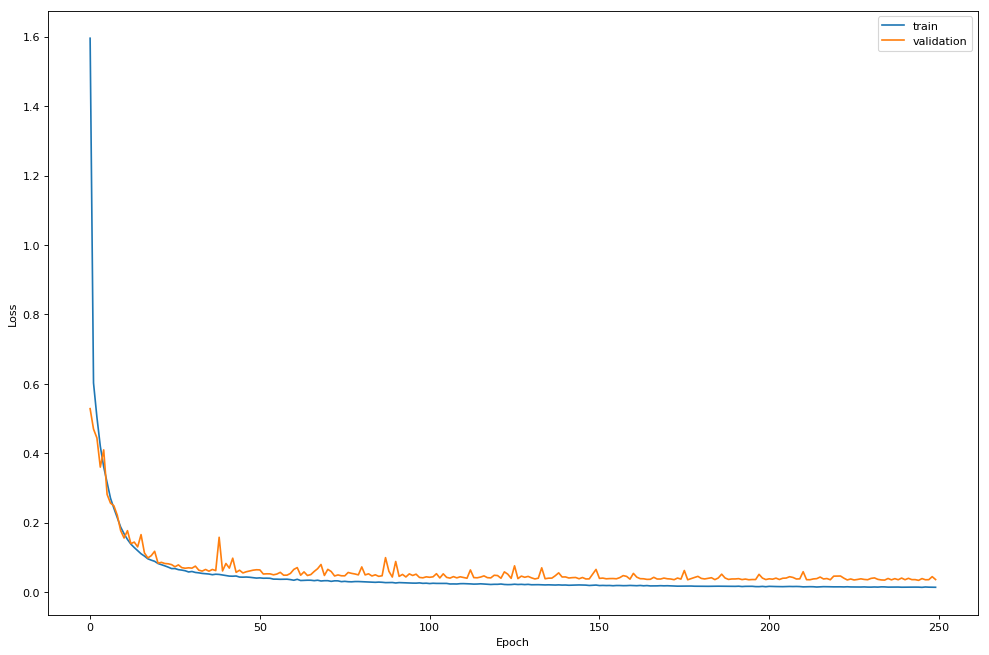

In [98]:
########################################## GRAFICADO DE PESOS
_= plt.hist(B2_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(B2_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(B2_grafico0.T,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(B2_grafico1.T,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(B2_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(B2_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

########################################## PERDIDAS
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(B1_history.history['loss'],label='train');
plt.plot(B1_history.history['val_loss'],label='validation');
plt.ylabel('Loss');
plt.xlabel('Epoch')
plt.legend();
plt.show()


> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

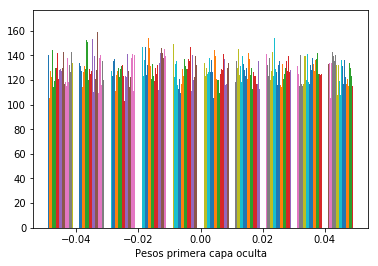

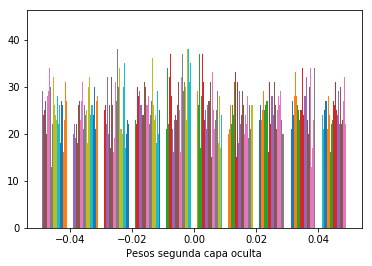

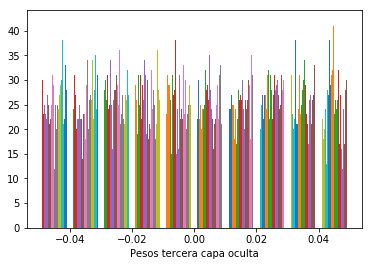

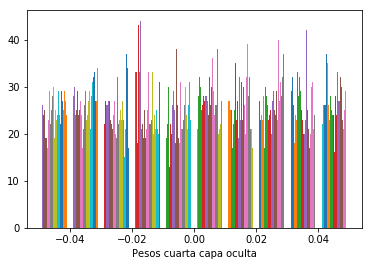

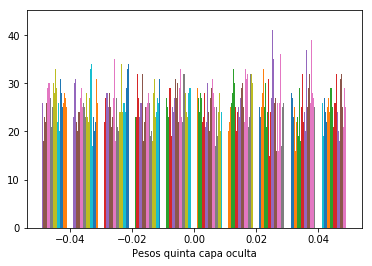

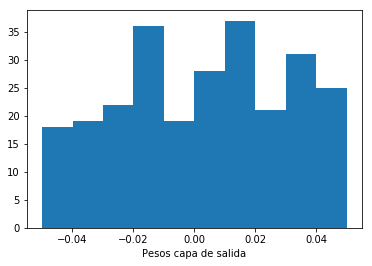

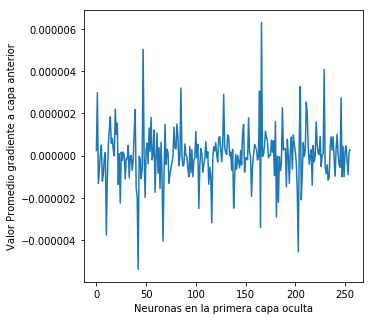

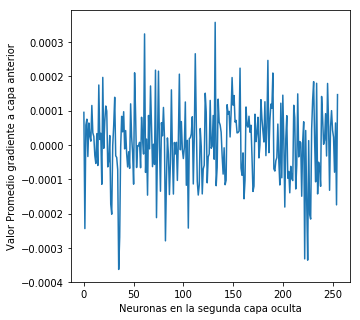

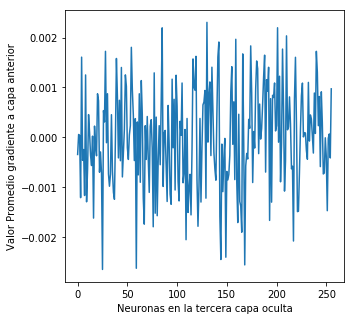

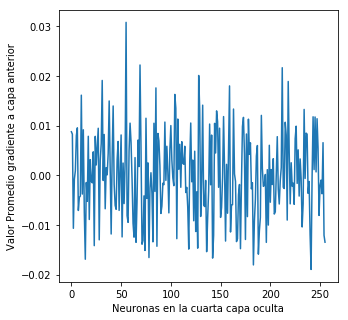

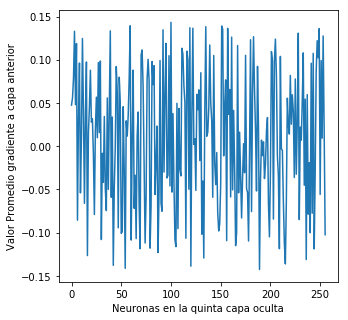

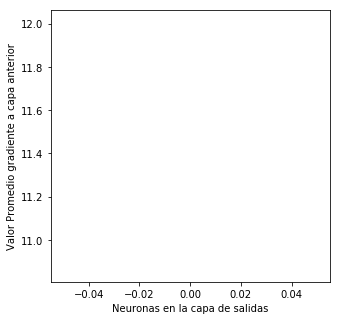

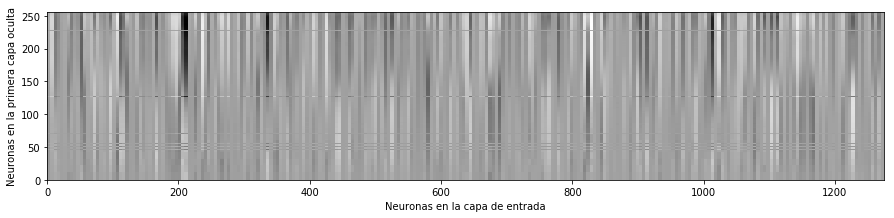

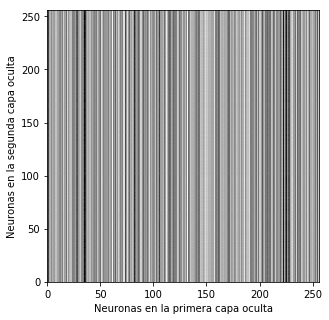

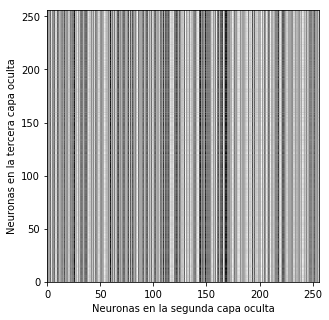

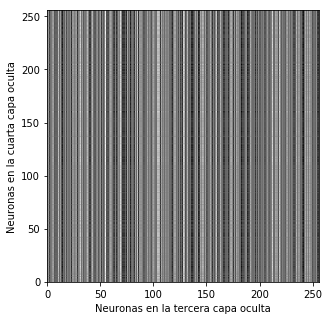

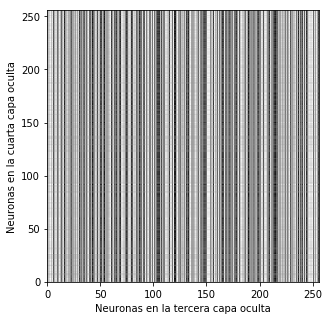

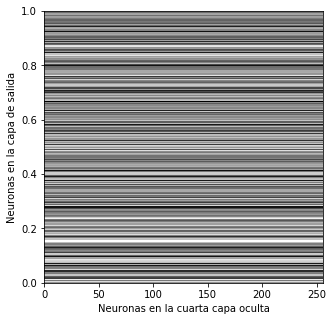

In [101]:
########################################## MODELO DE LA RED
C1_model = Sequential()
C1_model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
C1_model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
C1_model.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
C1_model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
C1_model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
C1_model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
C1_sgd = SGD(lr=0.01)
C1_model.compile(optimizer=C1_sgd,loss='mean_squared_error')

########################################## CALCULO DE LOS GRADIENTES
C1_loss = K.losses.mean_squared_error(C1_model.output,y_train)
C1_listOfVariableTensors = C1_model.trainable_weights
C1_gradients = k.gradients(C1_loss, C1_listOfVariableTensors)

C1_sess = k.get_session()

C1_evaluated_gradients = C1_sess.run(C1_gradients,feed_dict={ C1_model.input:X_train_scaled.values})
C1_evaluated_gradients = [gradient/len(y_train) for gradient in C1_evaluated_gradients]

########################################## OBTENCION DE PESOS 
C1_weights0, C1_biases0 = C1_model.layers[0].get_weights()
C1_weights1, C1_biases1 = C1_model.layers[1].get_weights()
C1_weights2, C1_biases2 = C1_model.layers[2].get_weights()
C1_weights3, C1_biases3 = C1_model.layers[3].get_weights()
C1_weights4, C1_biases4 = C1_model.layers[4].get_weights()
C1_weights5, C1_biases5 = C1_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
C1_grafico0=C1_evaluated_gradients[0]
C1_grafico1=C1_evaluated_gradients[2]
C1_grafico2=C1_evaluated_gradients[4]
C1_grafico3=C1_evaluated_gradients[6]
C1_grafico4=C1_evaluated_gradients[8]
C1_grafico5=C1_evaluated_gradients[10]

########################################## GRAFICADO DE PESOS
_= plt.hist(C1_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(C1_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(C1_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(C1_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(C1_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(C1_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(C1_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(C1_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(C1_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(C1_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(C1_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(C1_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(C1_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(C1_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(C1_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(C1_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(C1_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(C1_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

In [102]:
C1_history = C1_model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 13s 1ms/step - loss: 14.7092 - val_loss: 13.8338
Epoch 2/250
9745/9745 [==============================] - 5s 550us/step - loss: 14.0926 - val_loss: 14.1356
Epoch 3/250
9745/9745 [==============================] - 5s 526us/step - loss: 13.9831 - val_loss: 13.8182
Epoch 4/250
9745/9745 [==============================] - 5s 528us/step - loss: 13.8623 - val_loss: 14.0950
Epoch 5/250
9745/9745 [==============================] - 5s 525us/step - loss: 12.4577 - val_loss: 5.7761
Epoch 6/250
9745/9745 [==============================] - 5s 524us/step - loss: 2.0819 - val_loss: 1.0066
Epoch 7/250
9745/9745 [==============================] - 5s 524us/step - loss: 0.8753 - val_loss: 0.5980
Epoch 8/250
9745/9745 [==============================] - 5s 527us/step - loss: 0.6988 - val_loss: 0.5406
Epoch 9/250
9745/9745 [==============================] - 5s 524us/step - loss: 0.7080 - val_loss: 0.5009

Epoch 78/250
9745/9745 [==============================] - 5s 480us/step - loss: 0.0474 - val_loss: 0.0540
Epoch 79/250
9745/9745 [==============================] - 5s 473us/step - loss: 0.0540 - val_loss: 0.0942
Epoch 80/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.0544 - val_loss: 0.0578
Epoch 81/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0517 - val_loss: 0.0507
Epoch 82/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0491 - val_loss: 0.0748
Epoch 83/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0596 - val_loss: 0.0578
Epoch 84/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0573 - val_loss: 0.0529
Epoch 85/250
9745/9745 [==============================] - 5s 469us/step - loss: 0.0498 - val_loss: 0.0498
Epoch 86/250
9745/9745 [==============================] - 5s 464us/step - loss: 0.0522 - val_loss: 0.0522
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 5s 489us/step - loss: 0.0304 - val_loss: 0.0539
Epoch 156/250
9745/9745 [==============================] - 5s 489us/step - loss: 0.0326 - val_loss: 0.0492
Epoch 157/250
9745/9745 [==============================] - 5s 483us/step - loss: 0.0298 - val_loss: 0.0404
Epoch 158/250
9745/9745 [==============================] - 5s 506us/step - loss: 0.0302 - val_loss: 0.0378
Epoch 159/250
9745/9745 [==============================] - 5s 533us/step - loss: 0.0297 - val_loss: 0.0403
Epoch 160/250
9745/9745 [==============================] - 6s 570us/step - loss: 0.0351 - val_loss: 0.0505
Epoch 161/250
9745/9745 [==============================] - 5s 530us/step - loss: 0.0315 - val_loss: 0.0374
Epoch 162/250
9745/9745 [==============================] - 6s 571us/step - loss: 0.0355 - val_loss: 0.0485
Epoch 163/250
9745/9745 [==============================] - 5s 485us/step - loss: 0.0309 - val_loss: 0.1032
Epoch 164/250
9745/9745 [============

In [103]:
########################################## CALCULO DE LOS GRADIENTES
C2_loss = K.losses.mean_squared_error(C1_model.output,y_train)
C2_listOfVariableTensors = C1_model.trainable_weights
C2_gradients = k.gradients(C2_loss, C2_listOfVariableTensors)

C2_sess = k.get_session()

C2_evaluated_gradients = C2_sess.run(C2_gradients,feed_dict={ C1_model.input:X_train_scaled.values})
C2_evaluated_gradients = [gradient/len(y_train) for gradient in C2_evaluated_gradients]

########################################## OBTENCION DE PESOS 
C2_weights0, C2_biases0 = C1_model.layers[0].get_weights()
C2_weights1, C2_biases1 = C1_model.layers[1].get_weights()
C2_weights2, C2_biases2 = C1_model.layers[2].get_weights()
C2_weights3, C2_biases3 = C1_model.layers[3].get_weights()
C2_weights4, C2_biases4 = C1_model.layers[4].get_weights()
C2_weights5, C2_biases5 = C1_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
C2_grafico0=C2_evaluated_gradients[0]
C2_grafico1=C2_evaluated_gradients[2]
C2_grafico2=C2_evaluated_gradients[4]
C2_grafico3=C2_evaluated_gradients[6]
C2_grafico4=C2_evaluated_gradients[8]
C2_grafico5=C2_evaluated_gradients[10]

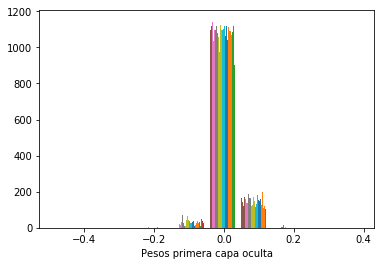

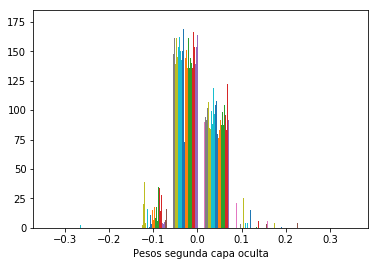

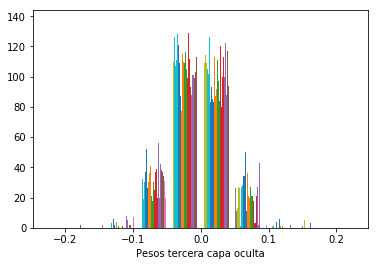

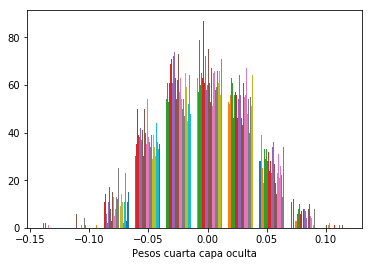

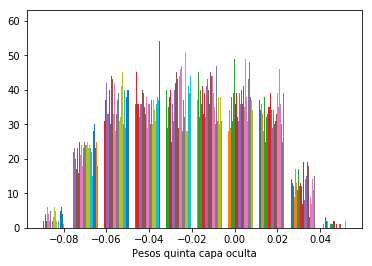

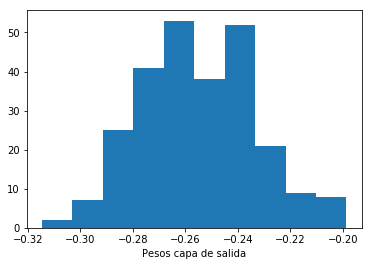

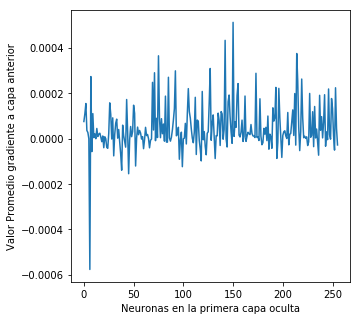

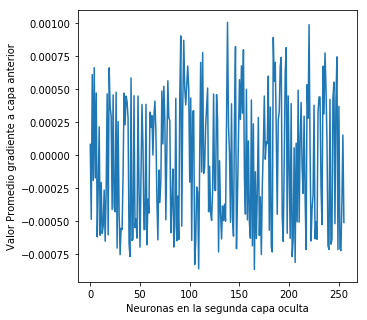

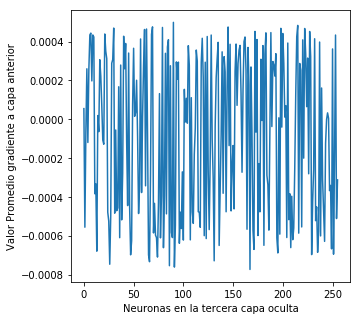

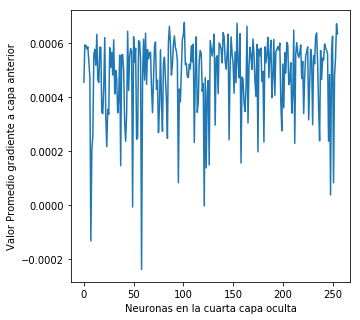

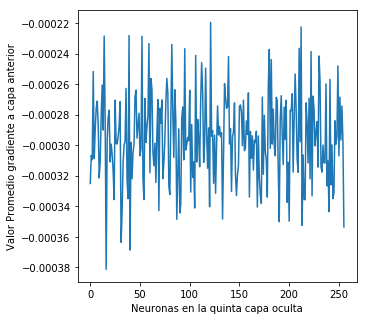

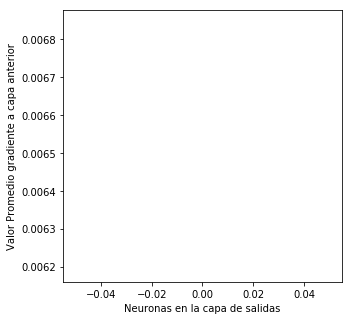

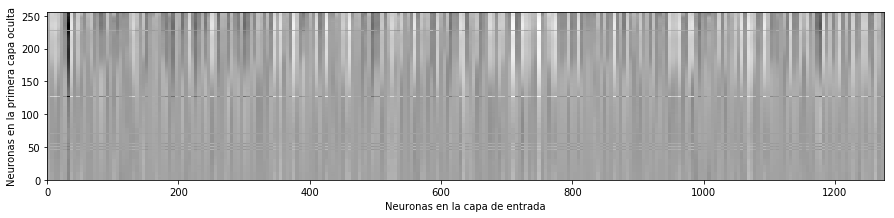

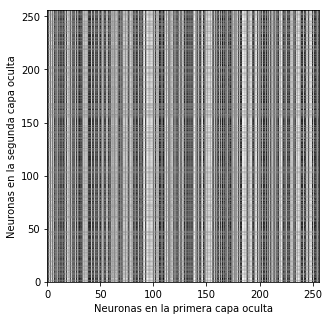

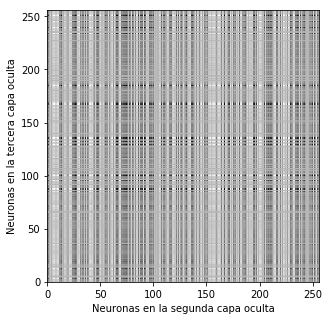

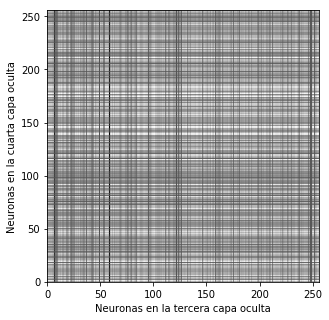

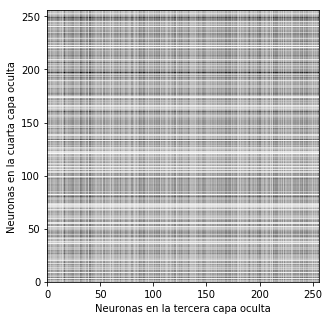

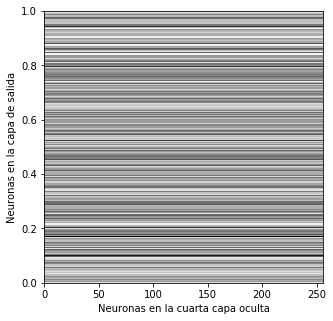

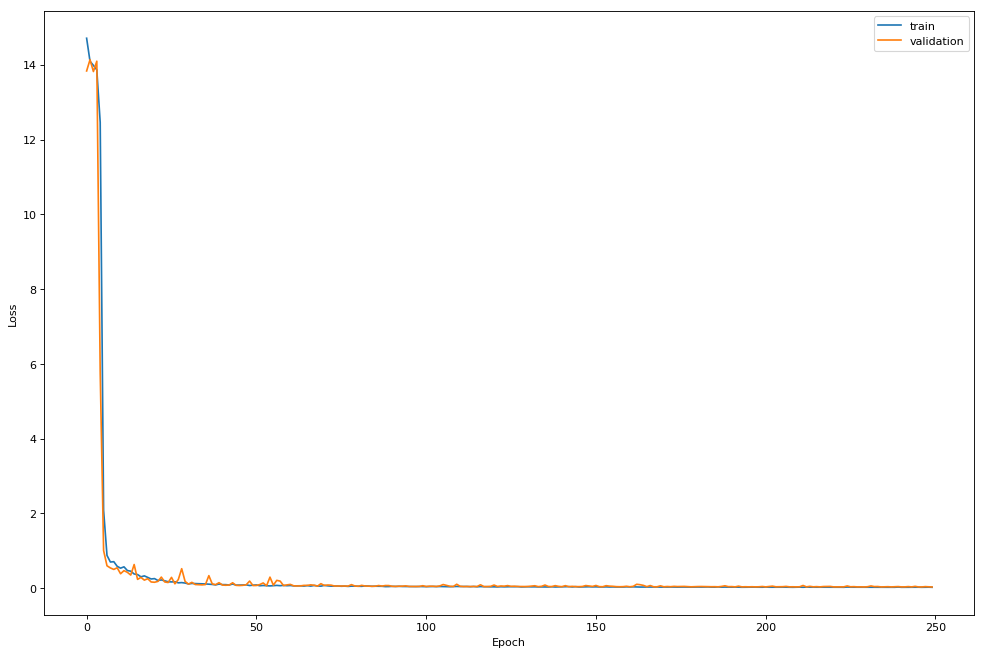

In [104]:
########################################## GRAFICADO DE PESOS
_= plt.hist(C2_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(C2_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(C2_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(C2_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(C2_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(C2_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(C2_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(C2_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(C2_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(C2_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(C2_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(C2_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(C2_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(C2_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(C2_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(C2_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(C2_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(C2_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

########################################## PERDIDAS
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(C1_history.history['loss'],label='train');
plt.plot(C1_history.history['val_loss'],label='validation');
plt.ylabel('Loss');
plt.xlabel('Epoch')
plt.legend();
plt.show()

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```


In [105]:
########################################## MODELO DE LA RED
D1_model = Sequential()
D1_model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
D1_model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
D1_model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
D1_model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
D1_model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
D1_model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
D1_sgd = SGD(lr=0.01)
D1_model.compile(optimizer=D1_sgd,loss='mean_squared_error')

########################################## CALCULO DE LOS GRADIENTES
D1_loss = K.losses.mean_squared_error(D1_model.output,y_train)
D1_listOfVariableTensors = D1_model.trainable_weights
D1_gradients = k.gradients(D1_loss, D1_listOfVariableTensors)

D1_sess = k.get_session()

D1_evaluated_gradients = D1_sess.run(D1_gradients,feed_dict={ D1_model.input:X_train_scaled.values})
D1_evaluated_gradients = [gradient/len(y_train) for gradient in D1_evaluated_gradients]

########################################## OBTENCION DE PESOS 
D1_weights0, D1_biases0 = D1_model.layers[0].get_weights()
D1_weights1, D1_biases1 = D1_model.layers[1].get_weights()
D1_weights2, D1_biases2 = D1_model.layers[2].get_weights()
D1_weights3, D1_biases3 = D1_model.layers[3].get_weights()
D1_weights4, D1_biases4 = D1_model.layers[4].get_weights()
D1_weights5, D1_biases5 = D1_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
D1_grafico0=D1_evaluated_gradients[0]
D1_grafico1=D1_evaluated_gradients[2]
D1_grafico2=D1_evaluated_gradients[4]
D1_grafico3=D1_evaluated_gradients[6]
D1_grafico4=D1_evaluated_gradients[8]
D1_grafico5=D1_evaluated_gradients[10]

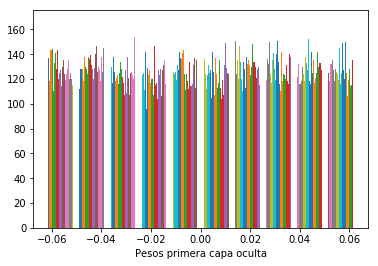

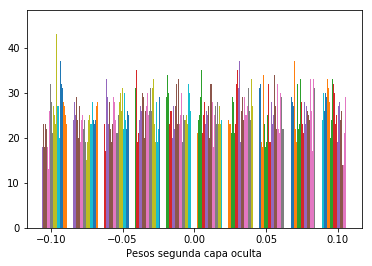

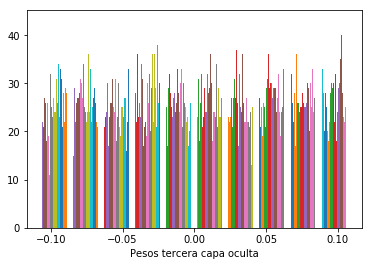

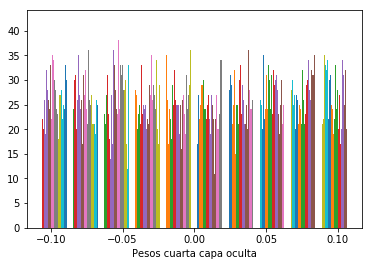

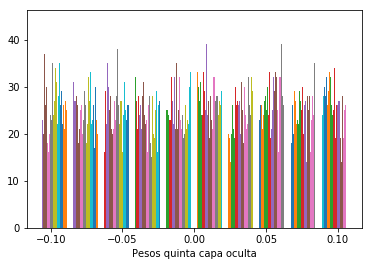

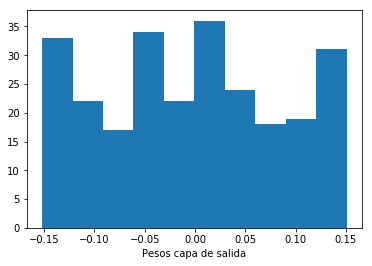

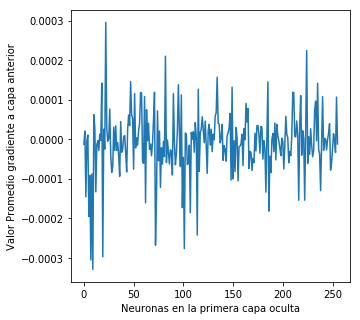

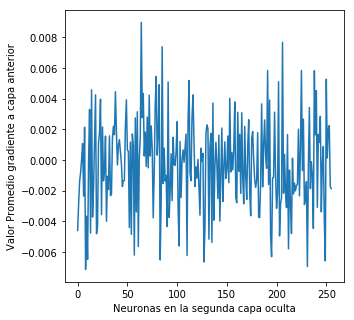

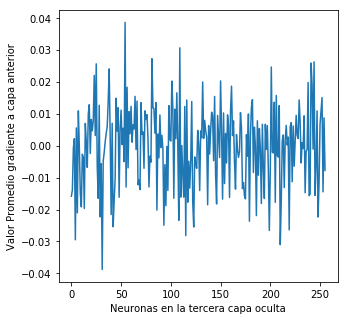

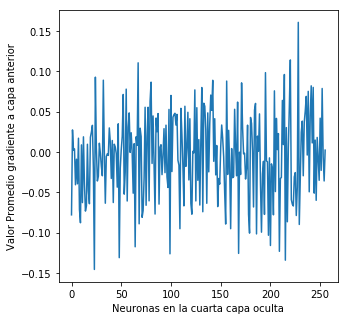

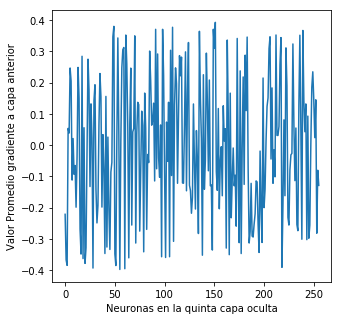

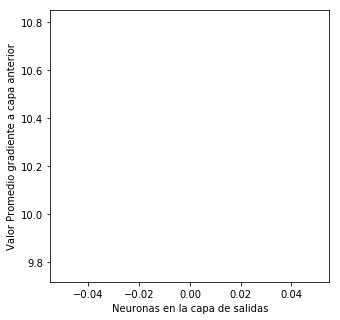

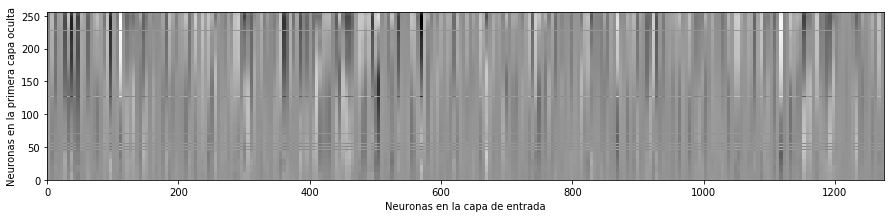

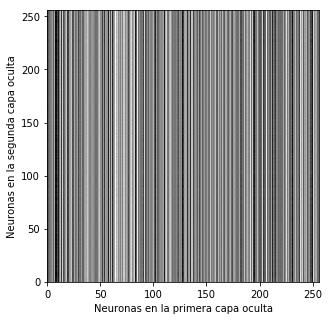

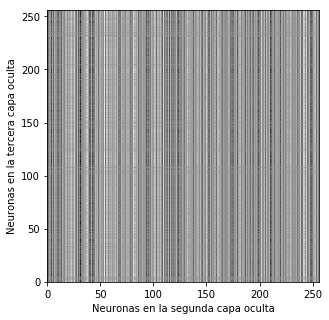

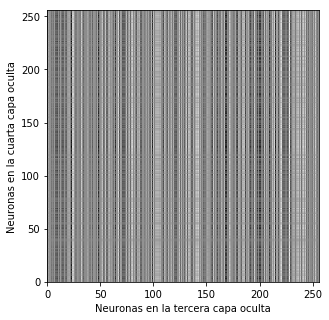

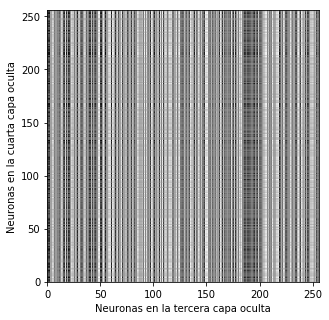

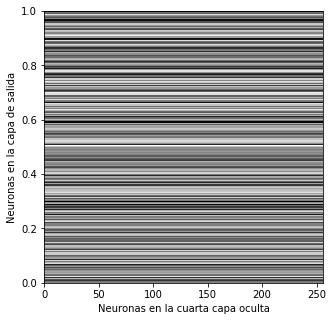

In [106]:
########################################## GRAFICADO DE PESOS
_= plt.hist(D1_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(D1_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(D1_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(D1_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(D1_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(D1_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(D1_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(D1_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(D1_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(D1_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(D1_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(D1_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(D1_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(D1_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(D1_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(D1_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(D1_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(D1_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

In [107]:
D1_history = D1_model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 11s 1ms/step - loss: 14.7025 - val_loss: 15.0034
Epoch 2/250
9745/9745 [==============================] - 5s 472us/step - loss: 6.2093 - val_loss: 1.9739
Epoch 3/250
9745/9745 [==============================] - 5s 473us/step - loss: 1.7807 - val_loss: 1.1806
Epoch 4/250
9745/9745 [==============================] - 5s 469us/step - loss: 1.2216 - val_loss: 0.6240
Epoch 5/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.9816 - val_loss: 1.4292
Epoch 6/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.7951 - val_loss: 0.5026
Epoch 7/250
9745/9745 [==============================] - 5s 469us/step - loss: 0.7291 - val_loss: 0.4776
Epoch 8/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.5902 - val_loss: 0.3292
Epoch 9/250
9745/9745 [==============================] - 5s 472us/step - loss: 0.5048 - val_loss: 0.3369
Epoch 

Epoch 78/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0579 - val_loss: 0.0558
Epoch 79/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0518 - val_loss: 0.0496
Epoch 80/250
9745/9745 [==============================] - 5s 464us/step - loss: 0.0473 - val_loss: 0.0517
Epoch 81/250
9745/9745 [==============================] - 5s 466us/step - loss: 0.0488 - val_loss: 0.0874
Epoch 82/250
9745/9745 [==============================] - 5s 462us/step - loss: 0.0490 - val_loss: 0.0586
Epoch 83/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0592 - val_loss: 0.0670
Epoch 84/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0559 - val_loss: 0.0493
Epoch 85/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0484 - val_loss: 0.0482
Epoch 86/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.0428 - val_loss: 0.0574
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0274 - val_loss: 0.0389
Epoch 156/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0334 - val_loss: 0.0384
Epoch 157/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0297 - val_loss: 0.0684
Epoch 158/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0277 - val_loss: 0.0405
Epoch 159/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.0299 - val_loss: 0.0390
Epoch 160/250
9745/9745 [==============================] - 5s 463us/step - loss: 0.0274 - val_loss: 0.0511
Epoch 161/250
9745/9745 [==============================] - 5s 464us/step - loss: 0.0287 - val_loss: 0.0533
Epoch 162/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0266 - val_loss: 0.0421
Epoch 163/250
9745/9745 [==============================] - 4s 462us/step - loss: 0.0291 - val_loss: 0.0501
Epoch 164/250
9745/9745 [============

In [108]:
########################################## CALCULO DE LOS GRADIENTES
D2_loss = K.losses.mean_squared_error(D1_model.output,y_train)
D2_listOfVariableTensors = D1_model.trainable_weights
D2_gradients = k.gradients(D2_loss, D2_listOfVariableTensors)

D2_sess = k.get_session()

D2_evaluated_gradients = D2_sess.run(D2_gradients,feed_dict={ D1_model.input:X_train_scaled.values})
D2_evaluated_gradients = [gradient/len(y_train) for gradient in D2_evaluated_gradients]

########################################## OBTENCION DE PESOS 
D2_weights0, D2_biases0 = D1_model.layers[0].get_weights()
D2_weights1, D2_biases1 = D1_model.layers[1].get_weights()
D2_weights2, D2_biases2 = D1_model.layers[2].get_weights()
D2_weights3, D2_biases3 = D1_model.layers[3].get_weights()
D2_weights4, D2_biases4 = D1_model.layers[4].get_weights()
D2_weights5, D2_biases5 = D1_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
D2_grafico0=D2_evaluated_gradients[0]
D2_grafico1=D2_evaluated_gradients[2]
D2_grafico2=D2_evaluated_gradients[4]
D2_grafico3=D2_evaluated_gradients[6]
D2_grafico4=D2_evaluated_gradients[8]
D2_grafico5=D2_evaluated_gradients[10]

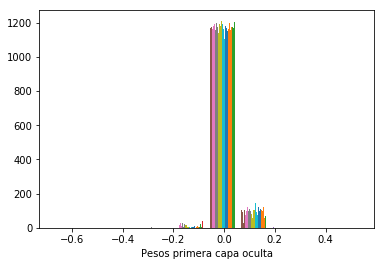

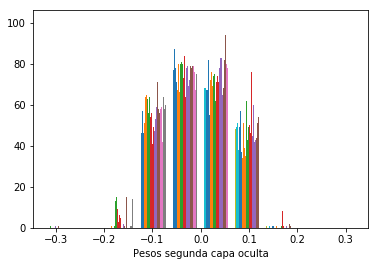

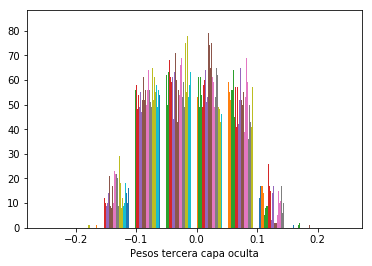

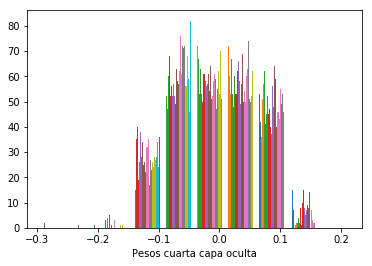

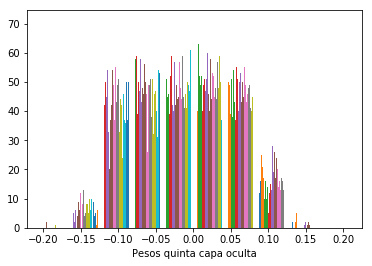

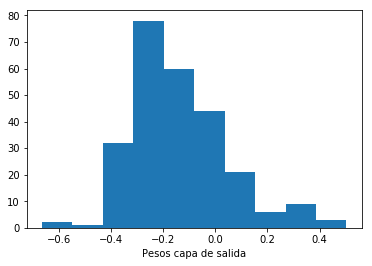

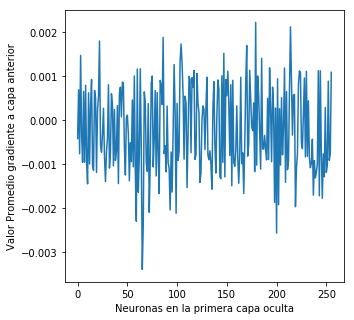

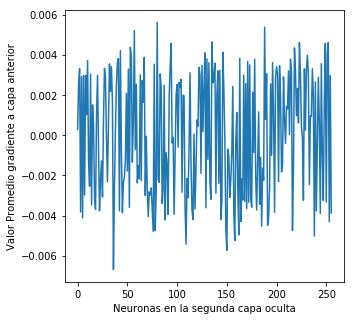

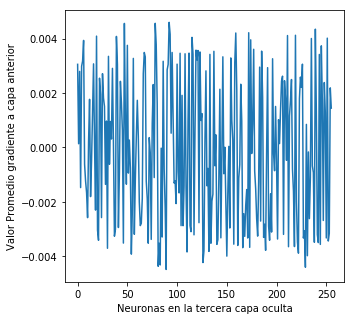

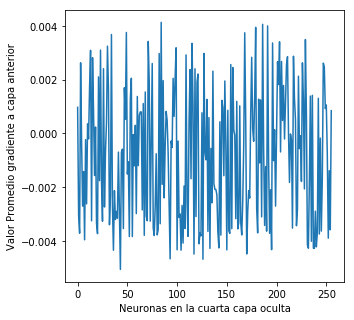

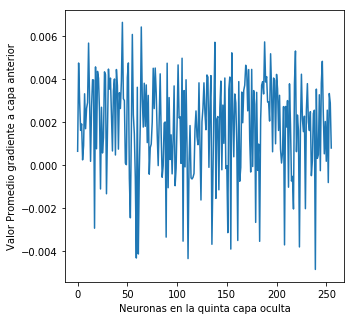

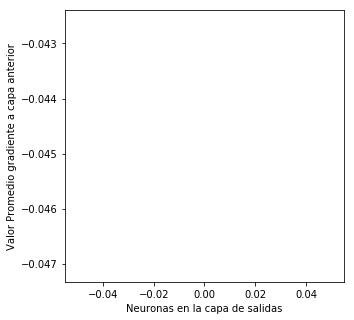

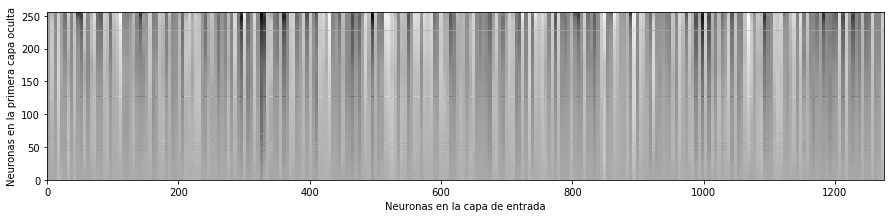

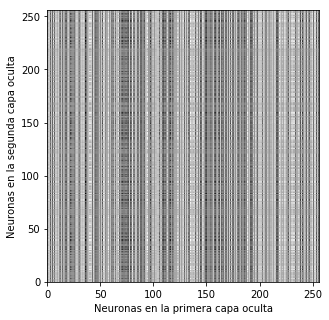

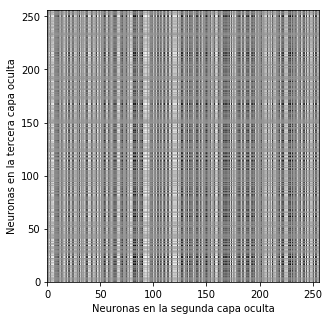

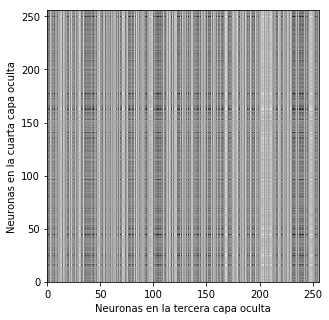

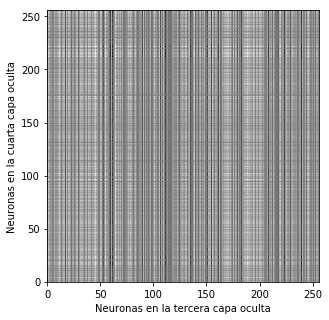

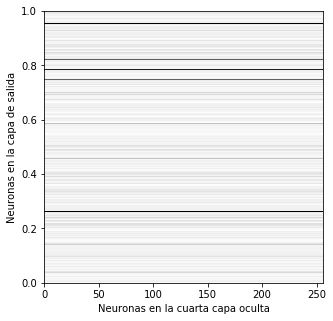

In [109]:
########################################## GRAFICADO DE PESOS
_= plt.hist(D2_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(D2_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(D2_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(D2_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(D2_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(D2_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(D2_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(D2_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(D2_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(D2_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(D2_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(D2_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(D2_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(D2_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(D2_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(D2_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(D2_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(D2_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')


> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.
```python
...
model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
...
or
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he
...
```


In [110]:
########################################## MODELO DE LA RED
E1a_model = Sequential()
E1a_model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
E1a_model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
E1a_model.add(Dense(256,  kernel_initializer='uniform',activation='relu'))
E1a_model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
E1a_model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
E1a_model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
E1a_sgd = SGD(lr=0.005)
E1a_model.compile(optimizer=E1a_sgd,loss='mean_squared_error')

########################################## CALCULO DE LOS GRADIENTES
E1a_loss = K.losses.mean_squared_error(E1a_model.output,y_train)
E1a_listOfVariableTensors = E1a_model.trainable_weights
E1a_gradients = k.gradients(E1a_loss, E1a_listOfVariableTensors)

E1a_sess = k.get_session()

E1a_evaluated_gradients = E1a_sess.run(E1a_gradients,feed_dict={ E1a_model.input:X_train_scaled.values})
E1a_evaluated_gradients = [gradient/len(y_train) for gradient in E1a_evaluated_gradients]

########################################## OBTENCION DE PESOS 
E1a_weights0, E1a_biases0 = E1a_model.layers[0].get_weights()
E1a_weights1, E1a_biases1 = E1a_model.layers[1].get_weights()
E1a_weights2, E1a_biases2 = E1a_model.layers[2].get_weights()
E1a_weights3, E1a_biases3 = E1a_model.layers[3].get_weights()
E1a_weights4, E1a_biases4 = E1a_model.layers[4].get_weights()
E1a_weights5, E1a_biases5 = E1a_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
E1a_grafico0=E1a_evaluated_gradients[0]
E1a_grafico1=E1a_evaluated_gradients[2]
E1a_grafico2=E1a_evaluated_gradients[4]
E1a_grafico3=E1a_evaluated_gradients[6]
E1a_grafico4=E1a_evaluated_gradients[8]
E1a_grafico5=E1a_evaluated_gradients[10]

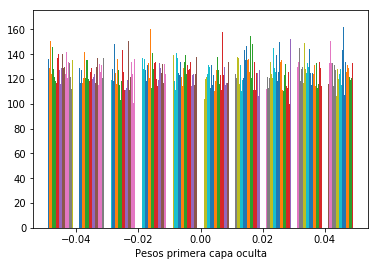

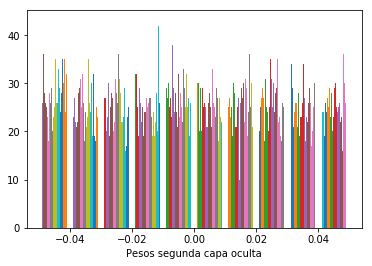

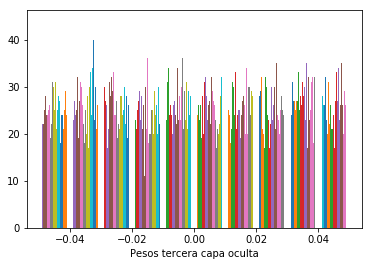

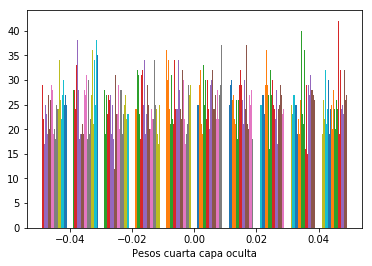

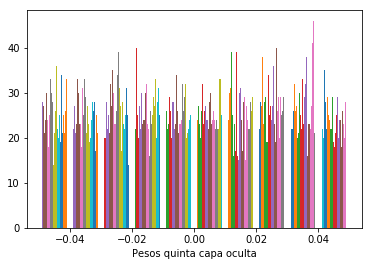

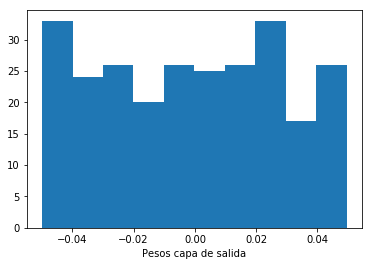

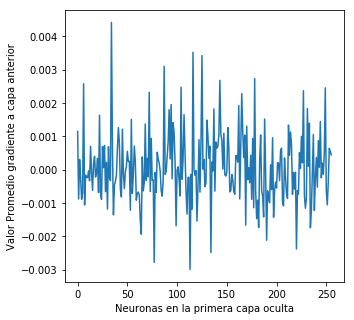

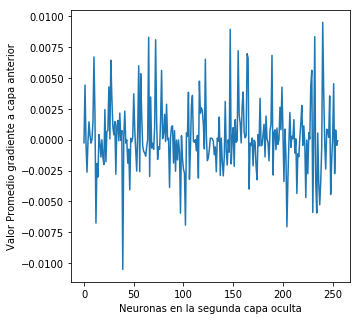

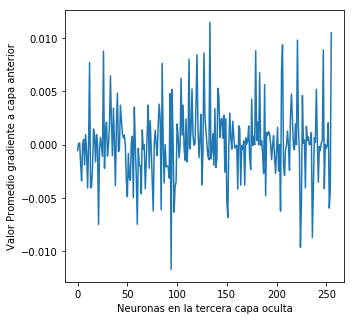

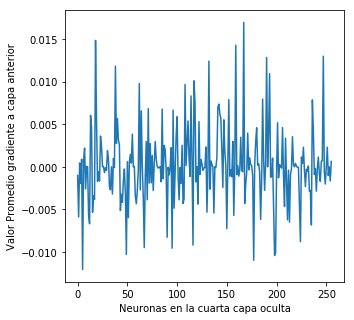

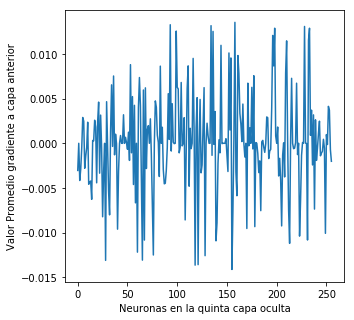

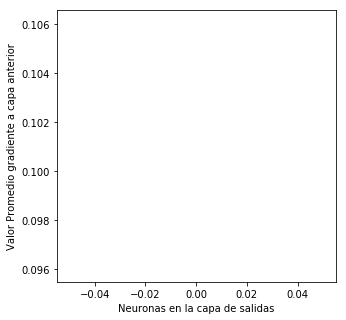

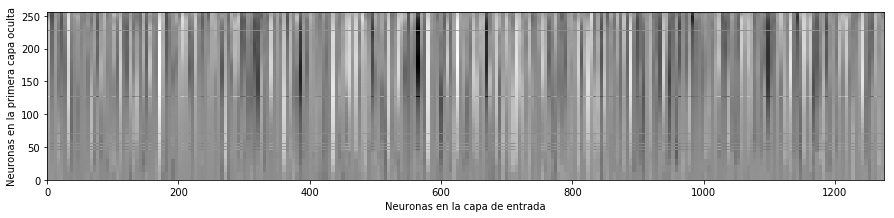

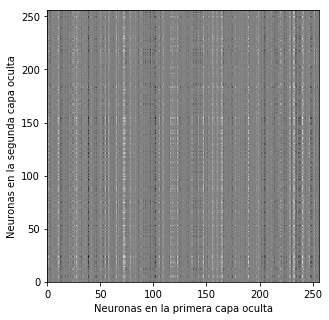

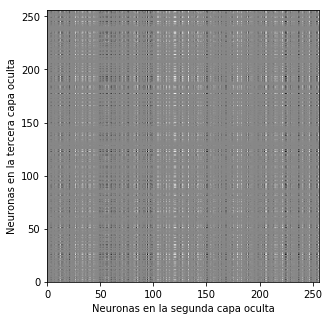

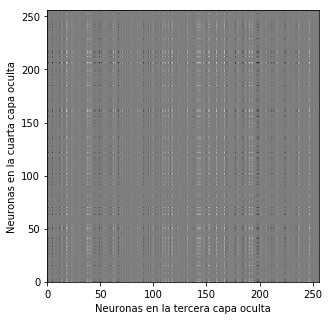

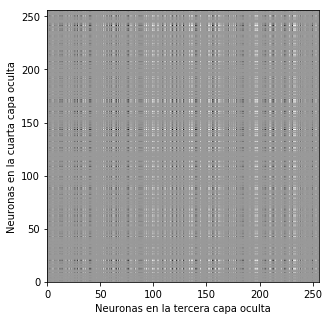

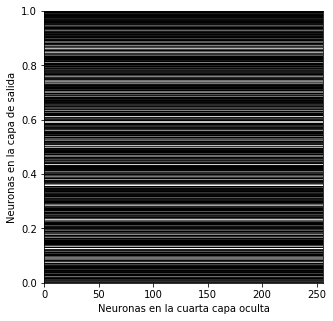

In [111]:
########################################## GRAFICADO DE PESOS
_= plt.hist(E1a_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(E1a_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(E1a_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(E1a_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(E1a_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(E1a_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(E1a_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(E1a_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(E1a_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(E1a_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(E1a_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(E1a_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(E1a_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(E1a_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(E1a_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E1a_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E1a_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(E1a_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

In [112]:
E1a_history = E1a_model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 11s 1ms/step - loss: 13.4475 - val_loss: 0.3651
Epoch 2/250
9745/9745 [==============================] - 5s 469us/step - loss: 0.5358 - val_loss: 0.4742
Epoch 3/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.3066 - val_loss: 0.2388
Epoch 4/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.2127 - val_loss: 0.2439
Epoch 5/250
9745/9745 [==============================] - 5s 466us/step - loss: 0.1661 - val_loss: 0.1169
Epoch 6/250
9745/9745 [==============================] - 5s 466us/step - loss: 0.1612 - val_loss: 0.1654
Epoch 7/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.1376 - val_loss: 0.1077
Epoch 8/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0986 - val_loss: 0.1080
Epoch 9/250
9745/9745 [==============================] - 5s 464us/step - loss: 0.0966 - val_loss: 0.1027
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0197 - val_loss: 0.0414
Epoch 79/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0195 - val_loss: 0.0387
Epoch 80/250
9745/9745 [==============================] - 5s 466us/step - loss: 0.0188 - val_loss: 0.0402
Epoch 81/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0181 - val_loss: 0.0411
Epoch 82/250
9745/9745 [==============================] - 5s 466us/step - loss: 0.0192 - val_loss: 0.0414
Epoch 83/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0183 - val_loss: 0.0379
Epoch 84/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.0175 - val_loss: 0.0412
Epoch 85/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0173 - val_loss: 0.0432
Epoch 86/250
9745/9745 [==============================] - 5s 472us/step - loss: 0.0174 - val_loss: 0.0436
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0119 - val_loss: 0.0338
Epoch 156/250
9745/9745 [==============================] - 5s 471us/step - loss: 0.0130 - val_loss: 0.0333
Epoch 157/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0125 - val_loss: 0.0376
Epoch 158/250
9745/9745 [==============================] - 5s 467us/step - loss: 0.0114 - val_loss: 0.0324
Epoch 159/250
9745/9745 [==============================] - 5s 465us/step - loss: 0.0113 - val_loss: 0.0366
Epoch 160/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.0116 - val_loss: 0.0355
Epoch 161/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0112 - val_loss: 0.0363
Epoch 162/250
9745/9745 [==============================] - 5s 469us/step - loss: 0.0113 - val_loss: 0.0327
Epoch 163/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0114 - val_loss: 0.0430
Epoch 164/250
9745/9745 [============

In [113]:
########################################## CALCULO DE LOS GRADIENTES
E2a_loss = K.losses.mean_squared_error(E1a_model.output,y_train)
E2a_listOfVariableTensors = E1a_model.trainable_weights
E2a_gradients = k.gradients(E2a_loss, E2a_listOfVariableTensors)

E2a_sess = k.get_session()

E2a_evaluated_gradients = E2a_sess.run(E2a_gradients,feed_dict={ E1a_model.input:X_train_scaled.values})
E2a_evaluated_gradients = [gradient/len(y_train) for gradient in E2a_evaluated_gradients]

########################################## OBTENCION DE PESOS 
E2a_weights0, E2a_biases0 = E1a_model.layers[0].get_weights()
E2a_weights1, E2a_biases1 = E1a_model.layers[1].get_weights()
E2a_weights2, E2a_biases2 = E1a_model.layers[2].get_weights()
E2a_weights3, E2a_biases3 = E1a_model.layers[3].get_weights()
E2a_weights4, E2a_biases4 = E1a_model.layers[4].get_weights()
E2a_weights5, E2a_biases5 = E1a_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
E2a_grafico0=E2a_evaluated_gradients[0]
E2a_grafico1=E2a_evaluated_gradients[2]
E2a_grafico2=E2a_evaluated_gradients[4]
E2a_grafico3=E2a_evaluated_gradients[6]
E2a_grafico4=E2a_evaluated_gradients[8]
E2a_grafico5=E2a_evaluated_gradients[10]

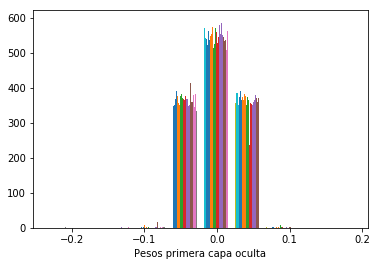

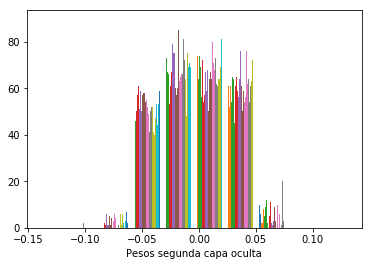

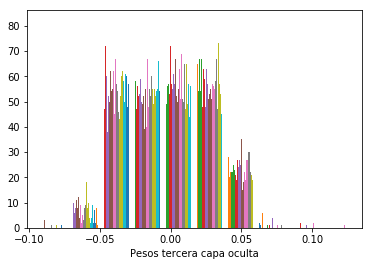

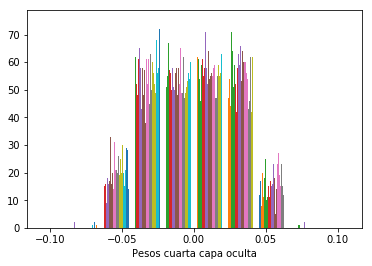

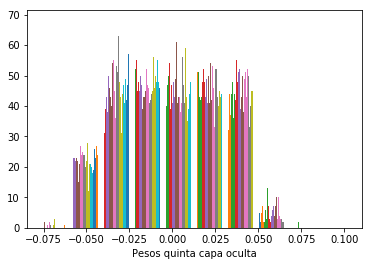

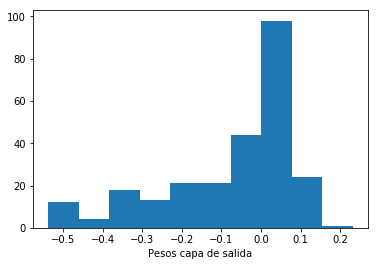

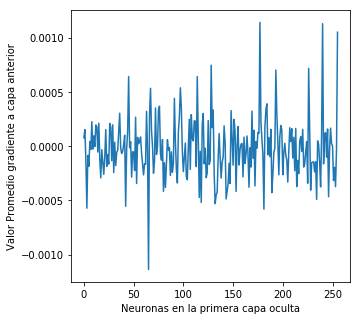

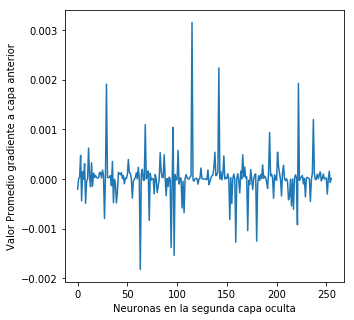

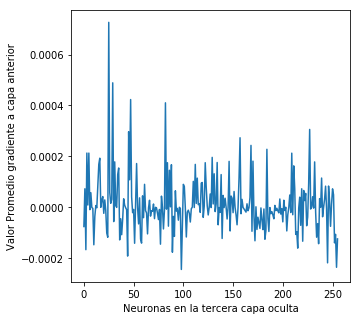

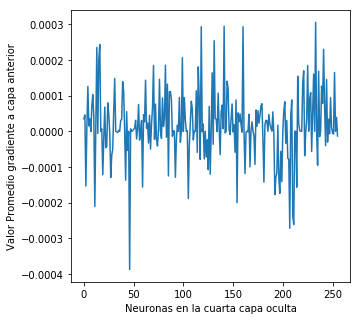

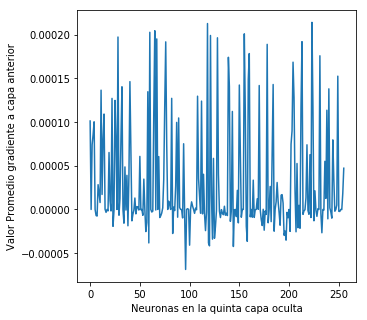

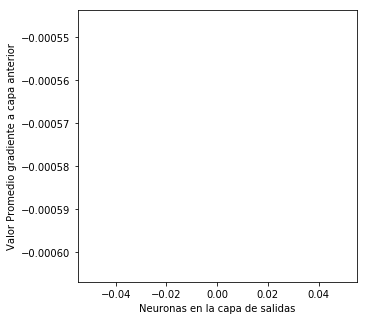

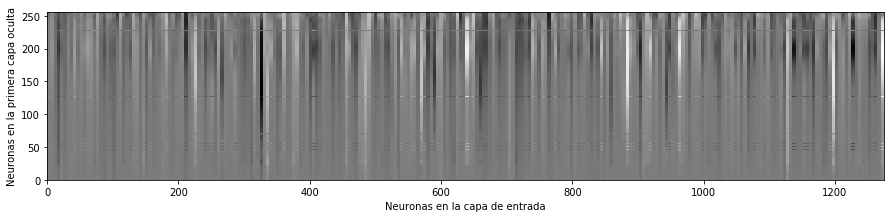

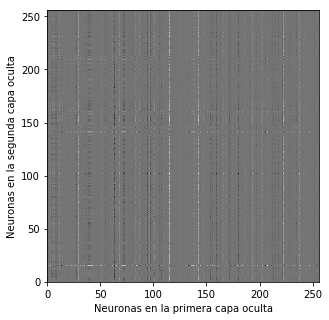

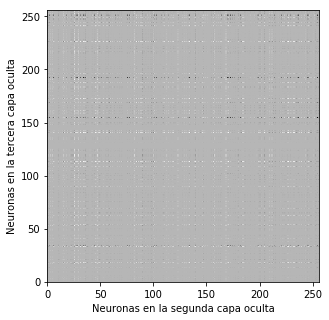

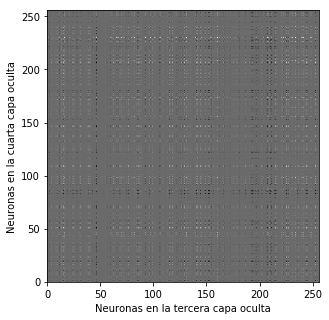

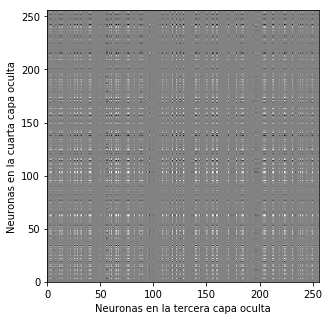

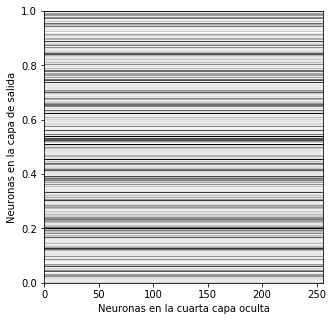

In [114]:
########################################## GRAFICADO DE PESOS
_= plt.hist(E2a_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(E2a_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(E2a_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(E2a_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(E2a_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(E2a_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(E2a_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(E2a_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(E2a_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(E2a_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(E2a_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(E2a_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(E2a_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(E2a_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(E2a_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E2a_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E2a_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(E2a_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

In [134]:
########################################## MODELO DE LA RED
E1b_model = Sequential()
E1b_model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
E1b_model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
E1b_model.add(Dense(256,  kernel_initializer='he_uniform',activation='relu'))
E1b_model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
E1b_model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
E1b_model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
E1b_sgd = SGD(lr=0.0001)
E1b_model.compile(optimizer=E1b_sgd,loss='mean_squared_error')

########################################## CALCULO DE LOS GRADIENTES
E1b_loss = K.losses.mean_squared_error(E1b_model.output,y_train)
E1b_listOfVariableTensors = E1b_model.trainable_weights
E1b_gradients = k.gradients(E1b_loss, E1b_listOfVariableTensors)

E1b_sess = k.get_session()

E1b_evaluated_gradients = E1b_sess.run(E1b_gradients,feed_dict={ E1b_model.input:X_train_scaled.values})
E1b_evaluated_gradients = [gradient/len(y_train) for gradient in E1b_evaluated_gradients]

########################################## OBTENCION DE PESOS 
E1b_weights0, E1b_biases0 = E1b_model.layers[0].get_weights()
E1b_weights1, E1b_biases1 = E1b_model.layers[1].get_weights()
E1b_weights2, E1b_biases2 = E1b_model.layers[2].get_weights()
E1b_weights3, E1b_biases3 = E1b_model.layers[3].get_weights()
E1b_weights4, E1b_biases4 = E1b_model.layers[4].get_weights()
E1b_weights5, E1b_biases5 = E1b_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
E1b_grafico0=E1b_evaluated_gradients[0]
E1b_grafico1=E1b_evaluated_gradients[2]
E1b_grafico2=E1b_evaluated_gradients[4]
E1b_grafico3=E1b_evaluated_gradients[6]
E1b_grafico4=E1b_evaluated_gradients[8]
E1b_grafico5=E1b_evaluated_gradients[10]

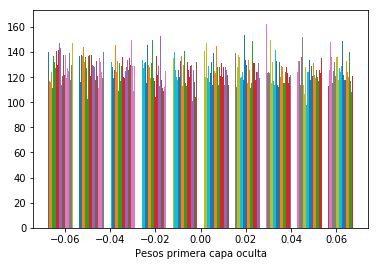

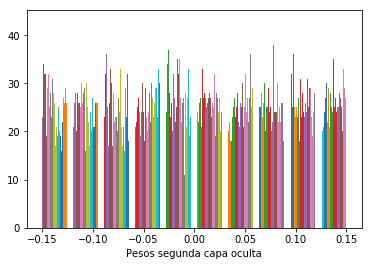

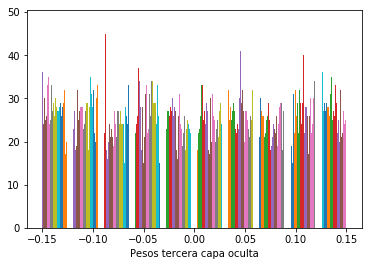

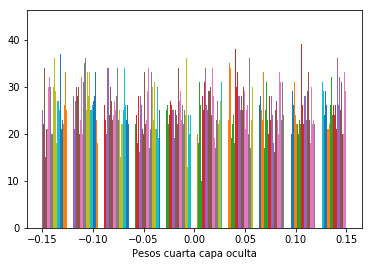

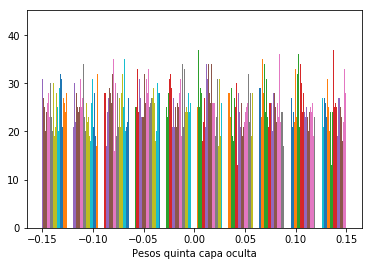

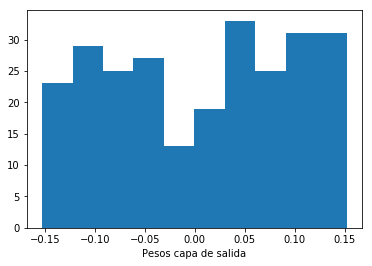

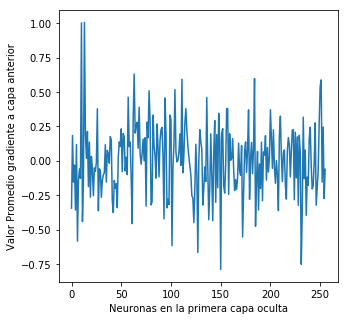

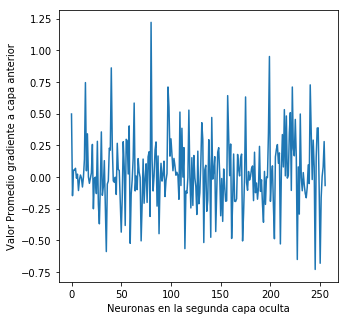

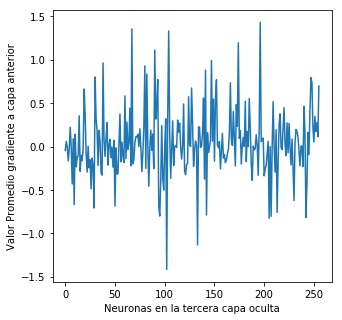

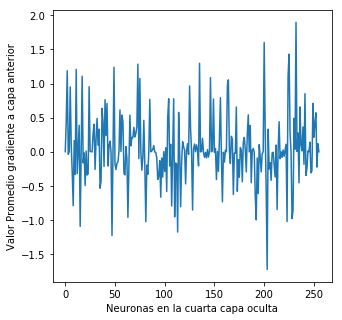

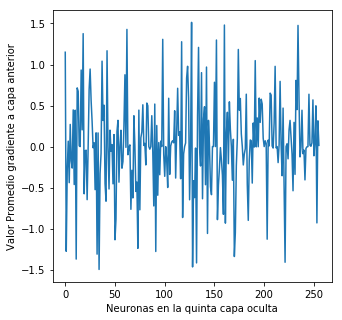

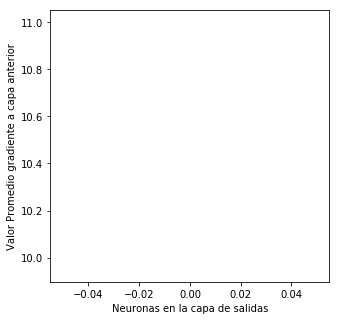

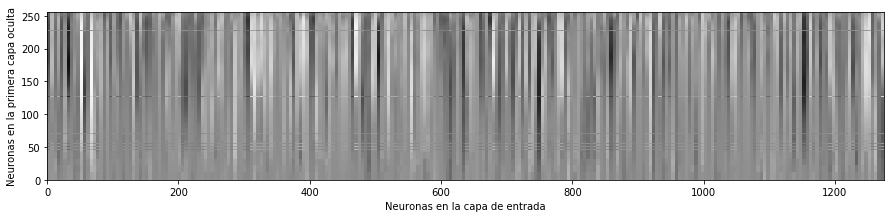

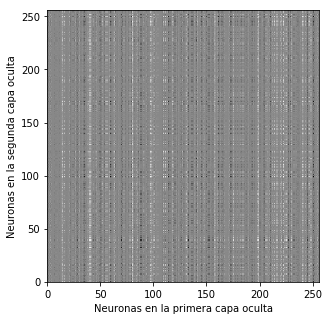

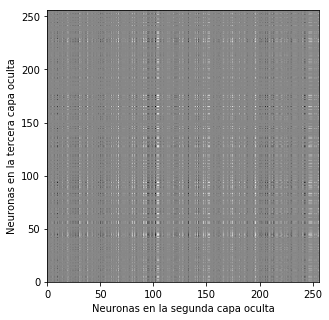

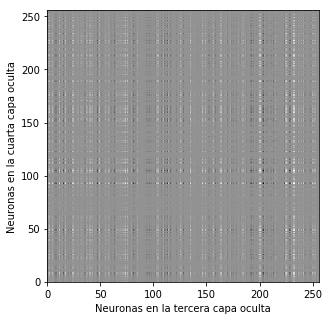

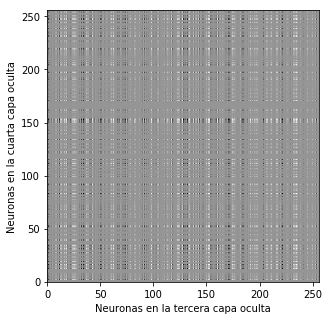

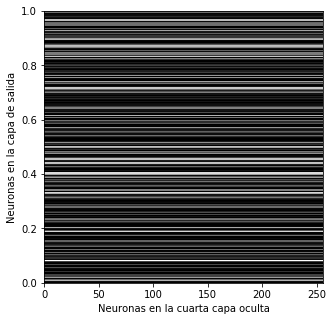

In [135]:
########################################## GRAFICADO DE PESOS
_= plt.hist(E1b_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(E1b_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(E1b_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(E1b_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(E1b_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(E1b_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(E1b_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(E1b_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(E1b_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(E1b_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(E1b_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(E1b_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(E1b_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(E1b_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(E1b_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E1b_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E1b_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(E1b_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')########################################## MODELO DE LA RED

In [136]:
E1b_history = E1b_model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 15s 2ms/step - loss: 12.5313 - val_loss: 3.9739
Epoch 2/250
9745/9745 [==============================] - 5s 478us/step - loss: 1.4545 - val_loss: 3.3004
Epoch 3/250
9745/9745 [==============================] - 5s 491us/step - loss: 0.8168 - val_loss: 2.7311
Epoch 4/250
9745/9745 [==============================] - 5s 478us/step - loss: 0.5763 - val_loss: 2.7522
Epoch 5/250
9745/9745 [==============================] - 5s 476us/step - loss: 0.4720 - val_loss: 2.5611
Epoch 6/250
9745/9745 [==============================] - 5s 483us/step - loss: 0.4065 - val_loss: 2.4582
Epoch 7/250
9745/9745 [==============================] - 5s 475us/step - loss: 0.3539 - val_loss: 2.5806
Epoch 8/250
9745/9745 [==============================] - 5s 474us/step - loss: 0.3150 - val_loss: 2.2404
Epoch 9/250
9745/9745 [==============================] - 5s 477us/step - loss: 0.2892 - val_loss: 2.2571
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 5s 486us/step - loss: 0.0507 - val_loss: 0.8479
Epoch 79/250
9745/9745 [==============================] - 5s 480us/step - loss: 0.0500 - val_loss: 0.8494
Epoch 80/250
9745/9745 [==============================] - 5s 482us/step - loss: 0.0484 - val_loss: 0.8669
Epoch 81/250
9745/9745 [==============================] - 5s 480us/step - loss: 0.0484 - val_loss: 0.8489
Epoch 82/250
9745/9745 [==============================] - 5s 483us/step - loss: 0.0473 - val_loss: 0.8567
Epoch 83/250
9745/9745 [==============================] - 5s 478us/step - loss: 0.0465 - val_loss: 0.8292
Epoch 84/250
9745/9745 [==============================] - 5s 480us/step - loss: 0.0464 - val_loss: 0.8190
Epoch 85/250
9745/9745 [==============================] - 5s 479us/step - loss: 0.0455 - val_loss: 0.9039
Epoch 86/250
9745/9745 [==============================] - 5s 544us/step - loss: 0.0466 - val_loss: 0.8340
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 6s 586us/step - loss: 0.0291 - val_loss: 0.6855
Epoch 156/250
9745/9745 [==============================] - 7s 672us/step - loss: 0.0291 - val_loss: 0.7015
Epoch 157/250
9745/9745 [==============================] - 5s 559us/step - loss: 0.0287 - val_loss: 0.6741
Epoch 158/250
9745/9745 [==============================] - 5s 494us/step - loss: 0.0287 - val_loss: 0.6697
Epoch 159/250
9745/9745 [==============================] - 5s 494us/step - loss: 0.0287 - val_loss: 0.6861
Epoch 160/250
9745/9745 [==============================] - 5s 490us/step - loss: 0.0285 - val_loss: 0.6724
Epoch 161/250
9745/9745 [==============================] - 5s 495us/step - loss: 0.0287 - val_loss: 0.6765
Epoch 162/250
9745/9745 [==============================] - 5s 495us/step - loss: 0.0279 - val_loss: 0.6669
Epoch 163/250
9745/9745 [==============================] - 5s 491us/step - loss: 0.0283 - val_loss: 0.6859
Epoch 164/250
9745/9745 [============

In [137]:
########################################## CALCULO DE LOS GRADIENTES
E2b_loss = K.losses.mean_squared_error(E1b_model.output,y_train)
E2b_listOfVariableTensors = E1b_model.trainable_weights
E2b_gradients = k.gradients(E2b_loss, E2b_listOfVariableTensors)

E2b_sess = k.get_session()

E2b_evaluated_gradients = E2b_sess.run(E2b_gradients,feed_dict={ E1b_model.input:X_train_scaled.values})
E2b_evaluated_gradients = [gradient/len(y_train) for gradient in E2b_evaluated_gradients]

########################################## OBTENCION DE PESOS 
E2b_weights0, E2b_biases0 = E1b_model.layers[0].get_weights()
E2b_weights1, E2b_biases1 = E1b_model.layers[1].get_weights()
E2b_weights2, E2b_biases2 = E1b_model.layers[2].get_weights()
E2b_weights3, E2b_biases3 = E1b_model.layers[3].get_weights()
E2b_weights4, E2b_biases4 = E1b_model.layers[4].get_weights()
E2b_weights5, E2b_biases5 = E1b_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
E2b_grafico0 = E2b_evaluated_gradients[0]
E2b_grafico1 = E2b_evaluated_gradients[2]
E2b_grafico2 = E2b_evaluated_gradients[4]
E2b_grafico3 = E2b_evaluated_gradients[6]
E2b_grafico4 = E2b_evaluated_gradients[8]
E2b_grafico5 = E2b_evaluated_gradients[10]

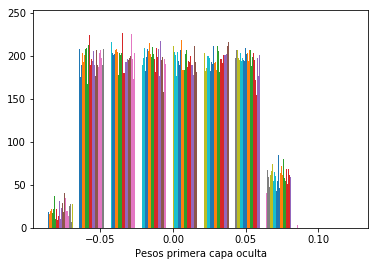

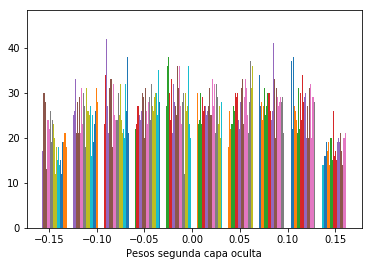

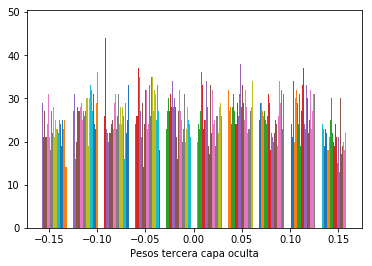

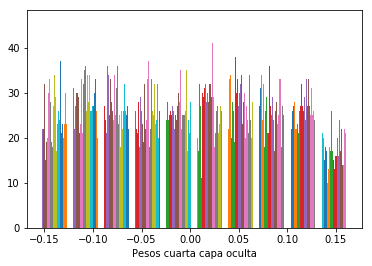

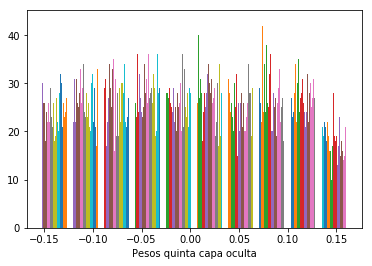

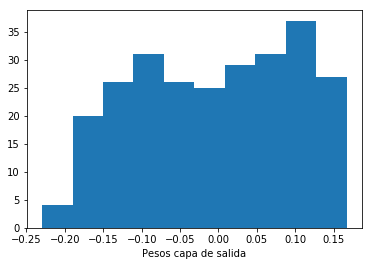

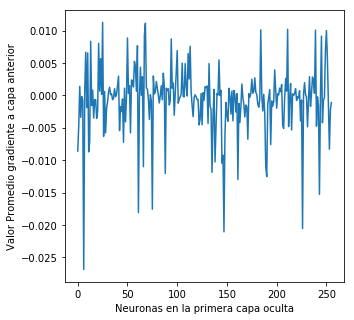

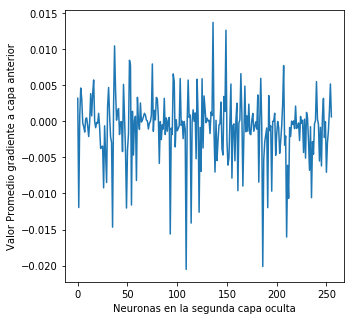

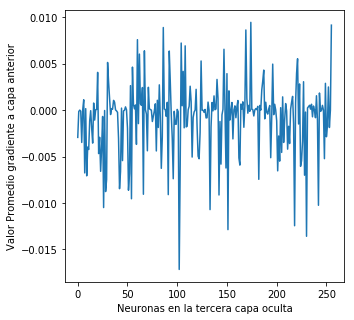

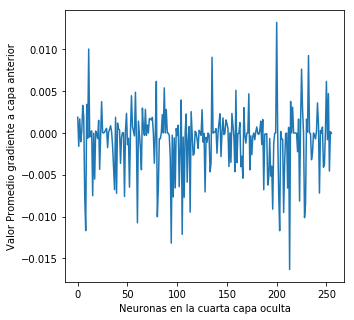

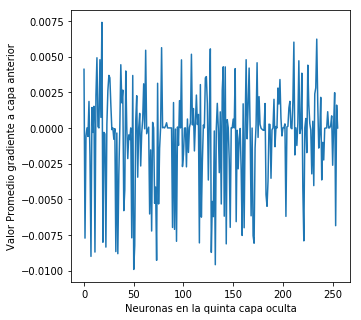

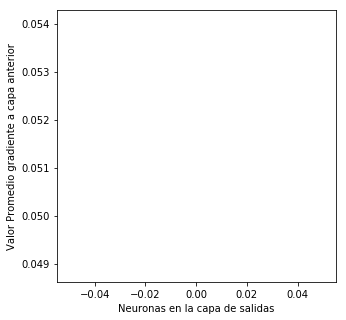

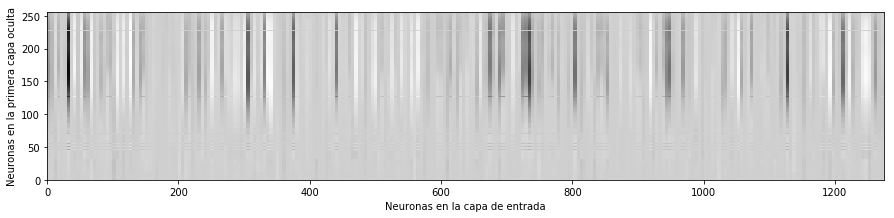

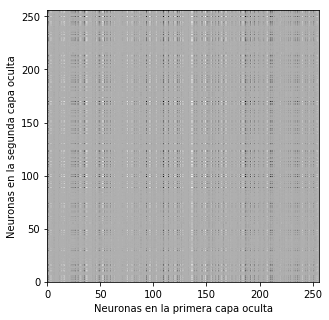

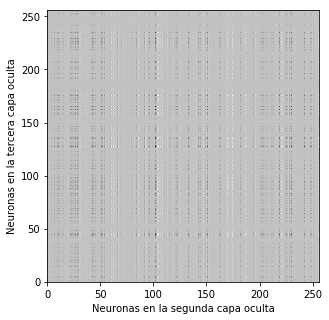

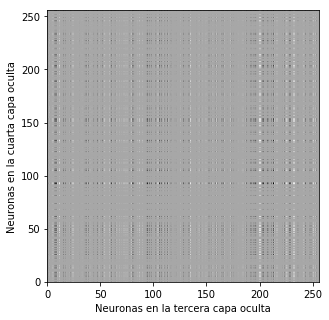

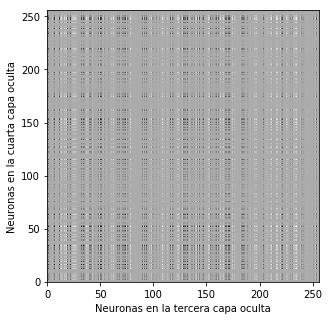

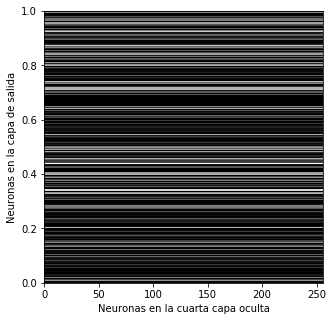

In [138]:
########################################## GRAFICADO DE PESOS
_= plt.hist(E2b_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(E2b_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(E2b_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(E2b_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(E2b_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(E2b_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(E2b_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(E2b_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(E2b_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(E2b_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(E2b_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(E2b_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(E2b_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(E2b_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(E2b_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E2b_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(E2b_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(E2b_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

> f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.



In [ ]:
Optimizadores = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adadelta']
Ratios = [0.0005, 0.001, 0.002, 0.003]
Inicializadores = ['uniform','random_uniform','glorot_uniform']
Activadores = ['sigmoid','relu','linear']
Resultados = []

for opt in Optimizadores:
    for rat in Ratios:
        F1_sgd = SGD(lr=rat)
        for ini in Inicializadores:
            for act in Activadores:
                F1_model = Sequential()
                F1_model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=ini,activation=act))
                F1_model.add(Dense(256, kernel_initializer=ini,activation=act))
                F1_model.add(Dense(256,  kernel_initializer=ini,activation=act))
                F1_model.add(Dense(256, kernel_initializer=ini,activation=act))
                F1_model.add(Dense(256, kernel_initializer=ini,activation=act))
                F1_model.add(Dense(1, kernel_initializer=ini,activation='linear'))
                F1_model.compile(optimizer=opt,loss='mean_squared_error')
                F1_history = F1_model.fit(X_train_scaled, y_train, epochs=100, verbose=1, validation_data=(X_val_scaled, y_val))
                Resultados.append('mean (Opt:'+opt+' Act:'+act+' Init:'+ini+' Ratio:'+str(rat)+')=' +str(K.losses.mean_squared_error(F1_model.output,y_train)))
for i in Resultados:
    print(i)

Train on 9745 samples, validate on 4060 samples
Epoch 1/100
9745/9745 [==============================] - 13s 1ms/step - loss: 14.8442 - val_loss: 21.8170
Epoch 2/100
9745/9745 [==============================] - 5s 516us/step - loss: 14.0379 - val_loss: 15.2357
Epoch 3/100
9745/9745 [==============================] - 5s 548us/step - loss: 13.9187 - val_loss: 13.7541
Epoch 4/100
9745/9745 [==============================] - 6s 662us/step - loss: 13.8596 - val_loss: 14.3915
Epoch 5/100
9745/9745 [==============================] - 6s 619us/step - loss: 9.7459 - val_loss: 2.3897
Epoch 6/100
9745/9745 [==============================] - 6s 656us/step - loss: 1.5288 - val_loss: 0.8343
Epoch 7/100
9745/9745 [==============================] - 6s 582us/step - loss: 0.8208 - val_loss: 0.6668
Epoch 8/100
9745/9745 [==============================] - 5s 491us/step - loss: 0.7161 - val_loss: 0.5178
Epoch 9/100
9745/9745 [==============================] - 5s 492us/step - loss: 0.6726 - val_loss: 0.7040


> g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.
```python
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='softplus')) #softplus
...
```


In [123]:
########################################## MODELO DE LA RED
G1_model = Sequential()
G1_model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='softplus'))
G1_model.add(Dense(256, kernel_initializer='uniform',activation='softplus'))
G1_model.add(Dense(256,  kernel_initializer='uniform',activation='softplus'))
G1_model.add(Dense(256, kernel_initializer='uniform',activation='softplus'))
G1_model.add(Dense(256, kernel_initializer='uniform',activation='softplus'))
G1_model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
G1_sgd = SGD(lr=0.01)
G1_model.compile(optimizer=G1_sgd,loss='mean_squared_error')

########################################## CALCULO DE LOS GRADIENTES
G1_loss = K.losses.mean_squared_error(G1_model.output,y_train)
G1_listOfVariableTensors = G1_model.trainable_weights
G1_gradients = k.gradients(G1_loss, G1_listOfVariableTensors)

G1_sess = k.get_session()

G1_evaluated_gradients = G1_sess.run(G1_gradients,feed_dict={ G1_model.input:X_train_scaled.values})
G1_evaluated_gradients = [gradient/len(y_train) for gradient in G1_evaluated_gradients]

########################################## OBTENCION DE PESOS 
G1_weights0, G1_biases0 = G1_model.layers[0].get_weights()
G1_weights1, G1_biases1 = G1_model.layers[1].get_weights()
G1_weights2, G1_biases2 = G1_model.layers[2].get_weights()
G1_weights3, G1_biases3 = G1_model.layers[3].get_weights()
G1_weights4, G1_biases4 = G1_model.layers[4].get_weights()
G1_weights5, G1_biases5 = G1_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
G1_grafico0=G1_evaluated_gradients[0]
G1_grafico1=G1_evaluated_gradients[2]
G1_grafico2=G1_evaluated_gradients[4]
G1_grafico3=G1_evaluated_gradients[6]
G1_grafico4=G1_evaluated_gradients[8]
G1_grafico5=G1_evaluated_gradients[10]


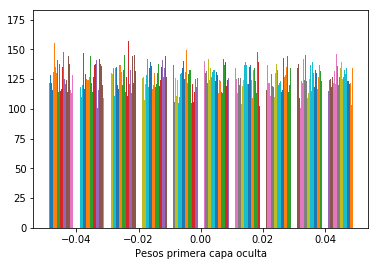

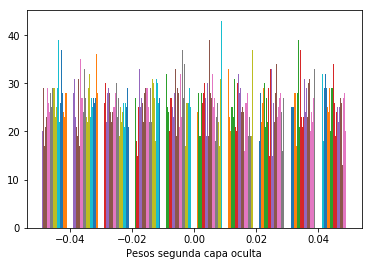

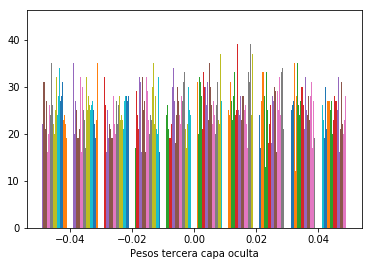

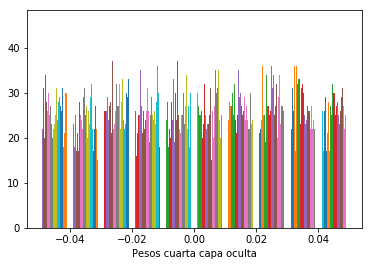

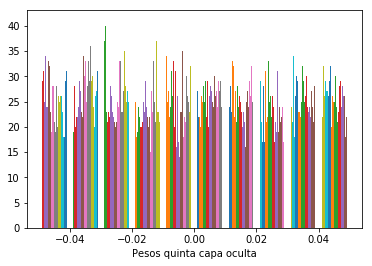

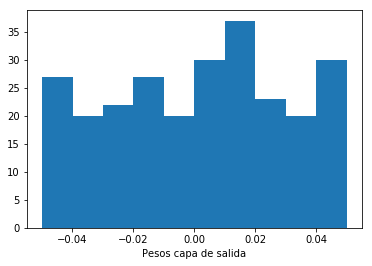

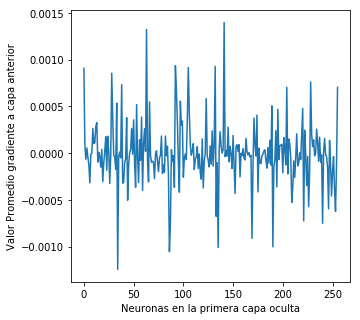

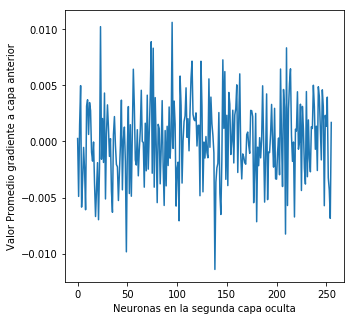

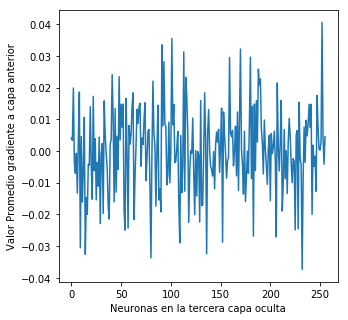

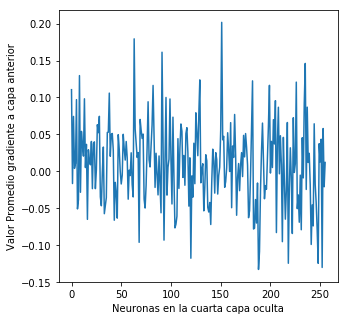

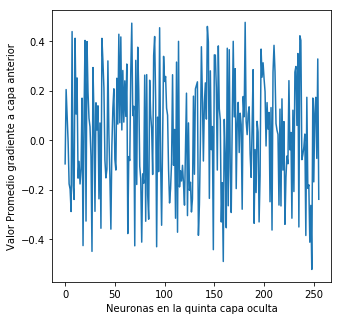

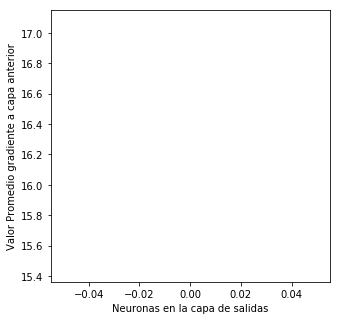

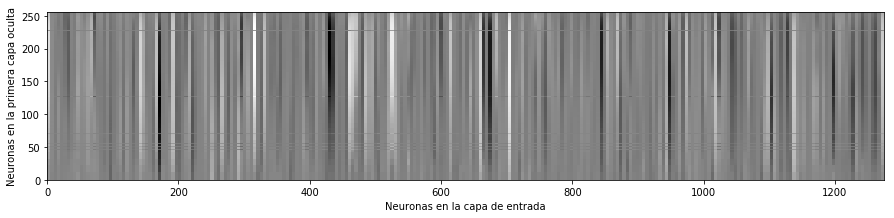

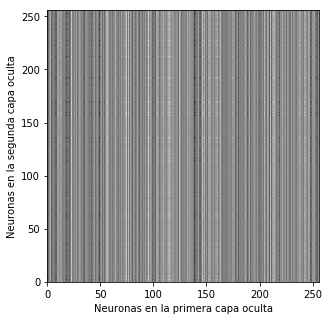

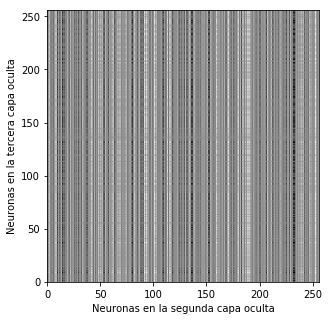

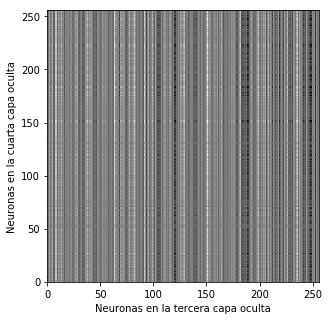

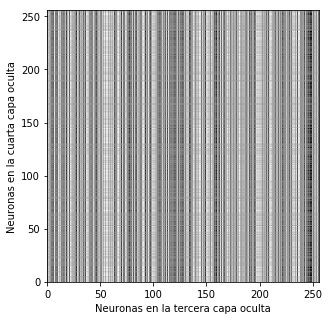

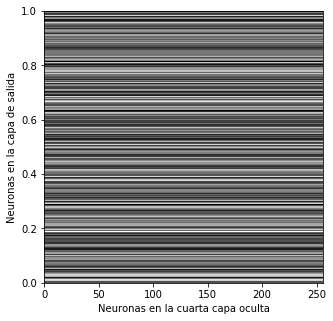

In [124]:
########################################## GRAFICADO DE PESOS
_= plt.hist(G1_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(G1_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(G1_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(G1_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(G1_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(G1_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(G1_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(G1_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(G1_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(G1_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(G1_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(G1_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(G1_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(G1_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(G1_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(G1_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(G1_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(G1_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

In [125]:
G1_history = G1_model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 12s 1ms/step - loss: 12.3994 - val_loss: 1.2020
Epoch 2/250
9745/9745 [==============================] - 5s 500us/step - loss: 0.8131 - val_loss: 0.3322
Epoch 3/250
9745/9745 [==============================] - 5s 498us/step - loss: 0.5092 - val_loss: 0.2275
Epoch 4/250
9745/9745 [==============================] - 5s 501us/step - loss: 0.3482 - val_loss: 0.2826
Epoch 5/250
9745/9745 [==============================] - 5s 497us/step - loss: 0.2761 - val_loss: 0.2484
Epoch 6/250
9745/9745 [==============================] - 5s 498us/step - loss: 0.2742 - val_loss: 0.3419
Epoch 7/250
9745/9745 [==============================] - 5s 497us/step - loss: 0.2535 - val_loss: 0.1788
Epoch 8/250
9745/9745 [==============================] - 5s 497us/step - loss: 0.2311 - val_loss: 0.1377
Epoch 9/250
9745/9745 [==============================] - 5s 498us/step - loss: 0.1938 - val_loss: 0.1812
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 5s 494us/step - loss: 0.0332 - val_loss: 0.0909
Epoch 79/250
9745/9745 [==============================] - 5s 496us/step - loss: 0.0363 - val_loss: 0.0544
Epoch 80/250
9745/9745 [==============================] - 5s 501us/step - loss: 0.0337 - val_loss: 0.0541
Epoch 81/250
9745/9745 [==============================] - 5s 498us/step - loss: 0.0439 - val_loss: 0.0451
Epoch 82/250
9745/9745 [==============================] - 5s 499us/step - loss: 0.0345 - val_loss: 0.0425
Epoch 83/250
9745/9745 [==============================] - 5s 493us/step - loss: 0.0306 - val_loss: 0.0466
Epoch 84/250
9745/9745 [==============================] - 5s 497us/step - loss: 0.0385 - val_loss: 0.0444
Epoch 85/250
9745/9745 [==============================] - 5s 498us/step - loss: 0.0360 - val_loss: 0.0922
Epoch 86/250
9745/9745 [==============================] - 5s 490us/step - loss: 0.0315 - val_loss: 0.0412
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 5s 496us/step - loss: 0.0228 - val_loss: 0.0571
Epoch 156/250
9745/9745 [==============================] - 5s 497us/step - loss: 0.0248 - val_loss: 0.0533
Epoch 157/250
9745/9745 [==============================] - 5s 494us/step - loss: 0.0240 - val_loss: 0.0538
Epoch 158/250
9745/9745 [==============================] - 5s 496us/step - loss: 0.0253 - val_loss: 0.0502
Epoch 159/250
9745/9745 [==============================] - 5s 494us/step - loss: 0.0248 - val_loss: 0.0614
Epoch 160/250
9745/9745 [==============================] - 5s 481us/step - loss: 0.0244 - val_loss: 0.0504
Epoch 161/250
9745/9745 [==============================] - 5s 497us/step - loss: 0.0269 - val_loss: 0.0396
Epoch 162/250
9745/9745 [==============================] - 5s 501us/step - loss: 0.0240 - val_loss: 0.0705
Epoch 163/250
9745/9745 [==============================] - 5s 495us/step - loss: 0.0230 - val_loss: 0.0406
Epoch 164/250
9745/9745 [============

In [126]:
########################################## CALCULO DE LOS GRADIENTES
G2_loss = K.losses.mean_squared_error(G1_model.output,y_train)
G2_listOfVariableTensors = G1_model.trainable_weights
G2_gradients = k.gradients(G2_loss, G2_listOfVariableTensors)

G2_sess = k.get_session()

G2_evaluated_gradients = G2_sess.run(G2_gradients,feed_dict={ G1_model.input:X_train_scaled.values})
G2_evaluated_gradients = [gradient/len(y_train) for gradient in G2_evaluated_gradients]

########################################## OBTENCION DE PESOS 
G2_weights0, G2_biases0 = G1_model.layers[0].get_weights()
G2_weights1, G2_biases1 = G1_model.layers[1].get_weights()
G2_weights2, G2_biases2 = G1_model.layers[2].get_weights()
G2_weights3, G2_biases3 = G1_model.layers[3].get_weights()
G2_weights4, G2_biases4 = G1_model.layers[4].get_weights()
G2_weights5, G2_biases5 = G1_model.layers[5].get_weights()

########################################## OBTENCION DE GRADIENTES
G2_grafico0=G2_evaluated_gradients[0]
G2_grafico1=G2_evaluated_gradients[2]
G2_grafico2=G2_evaluated_gradients[4]
G2_grafico3=G2_evaluated_gradients[6]
G2_grafico4=G2_evaluated_gradients[8]
G2_grafico5=G2_evaluated_gradients[10]

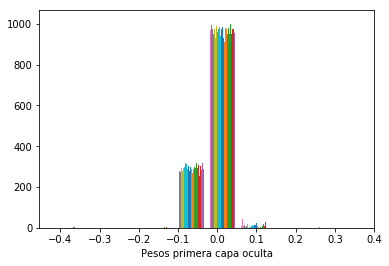

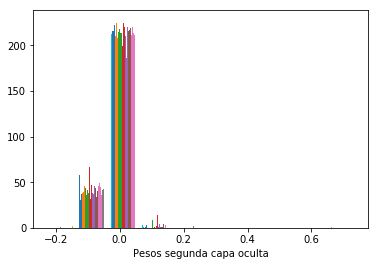

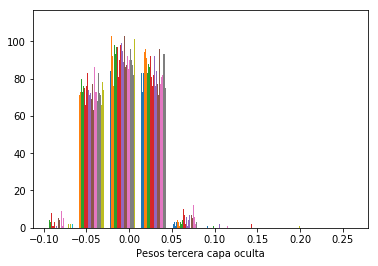

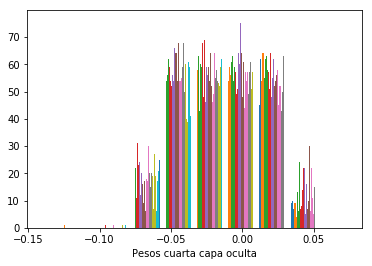

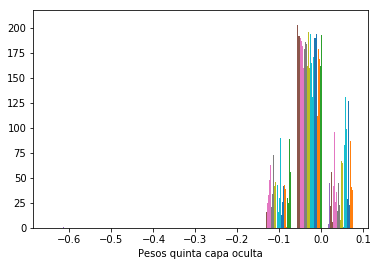

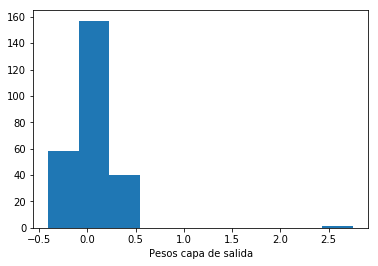

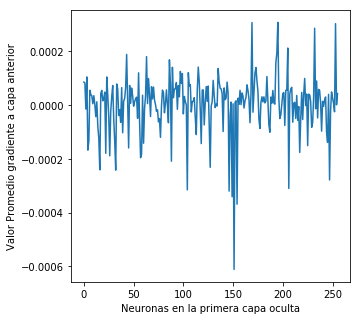

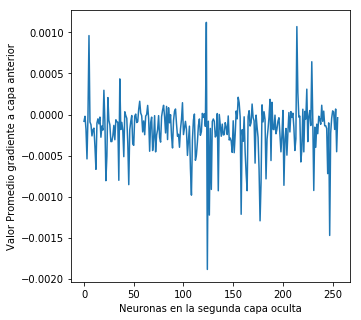

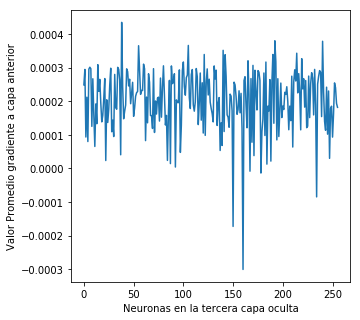

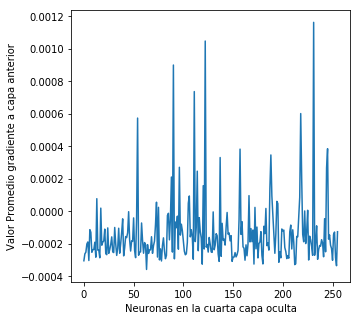

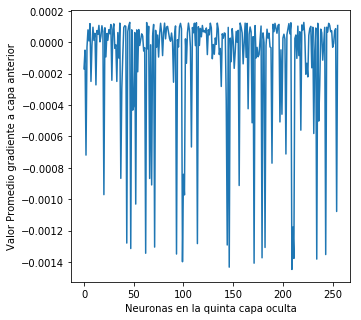

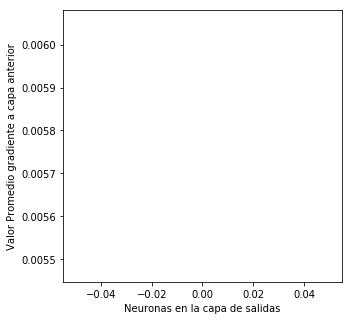

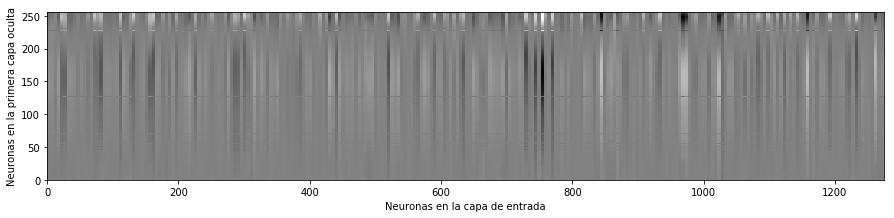

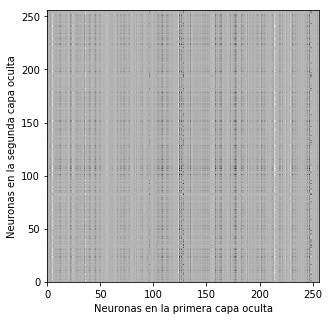

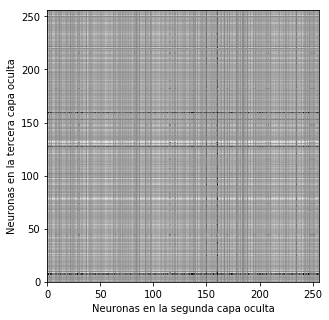

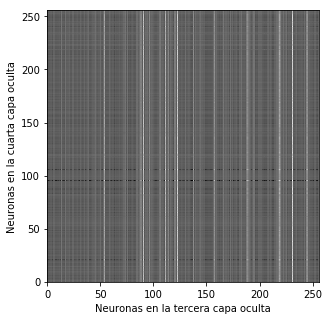

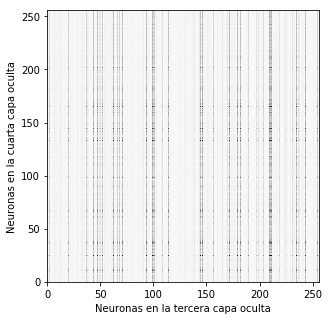

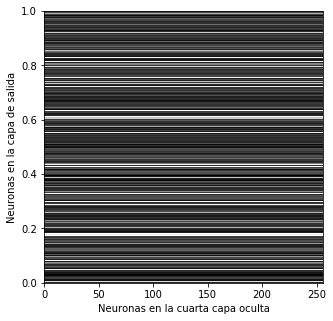

In [127]:
########################################## GRAFICADO DE PESOS
_= plt.hist(G2_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(G2_weights1)
_= plt.xlabel('Pesos segunda capa oculta')
plt.show()
_= plt.hist(G2_weights2)
_= plt.xlabel('Pesos tercera capa oculta')
plt.show()
_= plt.hist(G2_weights3)
_= plt.xlabel('Pesos cuarta capa oculta')
plt.show()
_= plt.hist(G2_weights4)
_= plt.xlabel('Pesos quinta capa oculta')
plt.show()
_= plt.hist(G2_weights5)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(G2_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la segunda capa oculta')
plt.plot(np.mean(G2_grafico1,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la tercera capa oculta')
plt.plot(np.mean(G2_grafico2,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
plt.plot(np.mean(G2_grafico3,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la quinta capa oculta')
plt.plot(np.mean(G2_grafico4,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(G2_grafico5,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(G2_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la segunda capa oculta')
plt.imshow(G2_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la segunda capa oculta')
_ = plt.ylabel('Neuronas en la tercera capa oculta')
plt.imshow(G2_grafico2, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(G2_grafico3, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la tercera capa oculta')
_ = plt.ylabel('Neuronas en la cuarta capa oculta')
plt.imshow(G2_grafico4, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la cuarta capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(G2_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

> h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?
```python
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='choose',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='choose',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))
```

In [128]:
########################################## MODELO DE LA RED
H1_model = Sequential()
H1_model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
H1_model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
H1_sgd = SGD(lr=0.0001)
H1_model.compile(optimizer=H1_sgd,loss='mean_squared_error')

########################################## CALCULO DE LOS GRADIENTES
H1_loss = K.losses.mean_squared_error(H1_model.output,y_train)
H1_listOfVariableTensors = H1_model.trainable_weights
H1_gradients = k.gradients(H1_loss, H1_listOfVariableTensors)

H1_sess = k.get_session()

H1_evaluated_gradients = H1_sess.run(H1_gradients,feed_dict={ H1_model.input:X_train_scaled.values})
H1_evaluated_gradients = [gradient/len(y_train) for gradient in H1_evaluated_gradients]

########################################## OBTENCION DE PESOS 
H1_weights0, H1_biases0 = H1_model.layers[0].get_weights()
H1_weights1, H1_biases1 = H1_model.layers[1].get_weights()

########################################## OBTENCION DE GRADIENTES
H1_grafico0=H1_evaluated_gradients[0]
H1_grafico1=H1_evaluated_gradients[2]

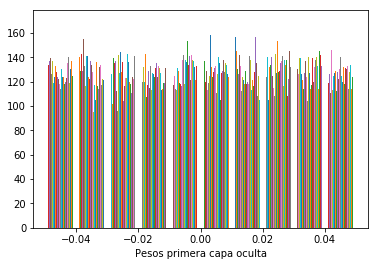

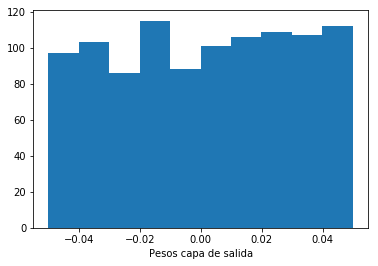

NameError: name 'H1_grafico5' is not defined

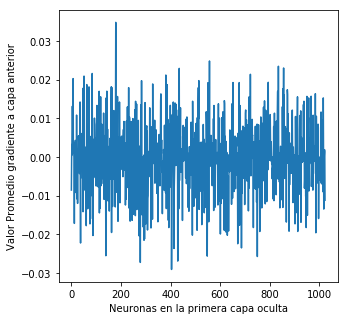

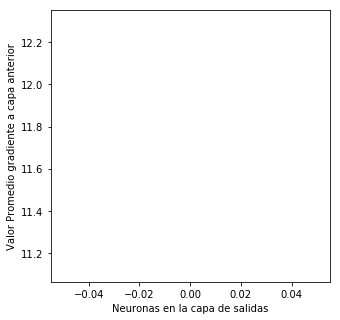

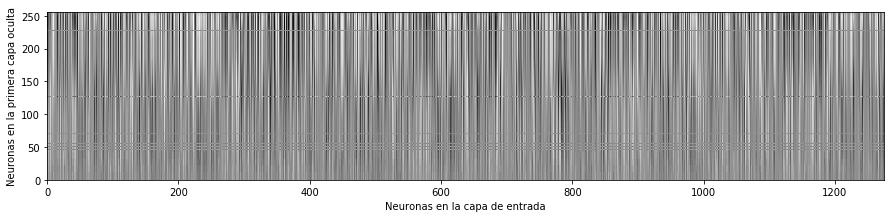

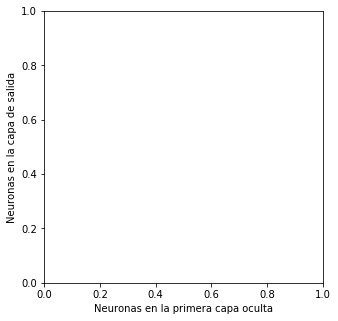

In [129]:
########################################## GRAFICADO DE PESOS
_= plt.hist(H1_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(H1_weights1)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(H1_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(H1_grafico1,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(H1_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(H1_grafico5, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')

In [130]:
H1_history = H1_model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 16s 2ms/step - loss: 9.2982 - val_loss: 1.9266
Epoch 2/250
9745/9745 [==============================] - 8s 837us/step - loss: 1.8707 - val_loss: 1.6082
Epoch 3/250
9745/9745 [==============================] - 8s 841us/step - loss: 1.7089 - val_loss: 1.5059
Epoch 4/250
9745/9745 [==============================] - 8s 844us/step - loss: 1.6139 - val_loss: 1.4123
Epoch 5/250
9745/9745 [==============================] - 9s 882us/step - loss: 1.5366 - val_loss: 1.3490
Epoch 6/250
9745/9745 [==============================] - 8s 867us/step - loss: 1.4716 - val_loss: 1.2751
Epoch 7/250
9745/9745 [==============================] - 9s 884us/step - loss: 1.4162 - val_loss: 1.2316
Epoch 8/250
9745/9745 [==============================] - 8s 850us/step - loss: 1.3672 - val_loss: 1.1936
Epoch 9/250
9745/9745 [==============================] - 9s 883us/step - loss: 1.3231 - val_loss: 1.1495
Epoch 10

Epoch 78/250
9745/9745 [==============================] - 7s 768us/step - loss: 0.6338 - val_loss: 0.5293
Epoch 79/250
9745/9745 [==============================] - 7s 769us/step - loss: 0.6318 - val_loss: 0.5274
Epoch 80/250
9745/9745 [==============================] - 7s 764us/step - loss: 0.6293 - val_loss: 0.5264
Epoch 81/250
9745/9745 [==============================] - 7s 765us/step - loss: 0.6268 - val_loss: 0.5260
Epoch 82/250
9745/9745 [==============================] - 7s 766us/step - loss: 0.6252 - val_loss: 0.5182
Epoch 83/250
9745/9745 [==============================] - 7s 765us/step - loss: 0.6230 - val_loss: 0.5193
Epoch 84/250
9745/9745 [==============================] - 7s 749us/step - loss: 0.6206 - val_loss: 0.5154
Epoch 85/250
9745/9745 [==============================] - 7s 770us/step - loss: 0.6186 - val_loss: 0.5157
Epoch 86/250
9745/9745 [==============================] - 7s 769us/step - loss: 0.6161 - val_loss: 0.5111
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 7s 768us/step - loss: 0.5217 - val_loss: 0.4444
Epoch 156/250
9745/9745 [==============================] - 7s 766us/step - loss: 0.5205 - val_loss: 0.4422
Epoch 157/250
9745/9745 [==============================] - 8s 770us/step - loss: 0.5194 - val_loss: 0.4415
Epoch 158/250
9745/9745 [==============================] - 7s 768us/step - loss: 0.5187 - val_loss: 0.4406
Epoch 159/250
9745/9745 [==============================] - 7s 768us/step - loss: 0.5176 - val_loss: 0.4428
Epoch 160/250
9745/9745 [==============================] - 7s 768us/step - loss: 0.5164 - val_loss: 0.4415
Epoch 161/250
9745/9745 [==============================] - 7s 766us/step - loss: 0.5155 - val_loss: 0.4403
Epoch 162/250
9745/9745 [==============================] - 7s 765us/step - loss: 0.5147 - val_loss: 0.4399
Epoch 163/250
9745/9745 [==============================] - 7s 764us/step - loss: 0.5139 - val_loss: 0.4389
Epoch 164/250
9745/9745 [============

In [131]:
########################################## CALCULO DE LOS GRADIENTES
H2_loss = K.losses.mean_squared_error(H1_model.output,y_train)
H2_listOfVariableTensors = H1_model.trainable_weights
H2_gradients = k.gradients(H2_loss, H2_listOfVariableTensors)

H2_sess = k.get_session()

H2_evaluated_gradients = H2_sess.run(H2_gradients,feed_dict={ H1_model.input:X_train_scaled.values})
H2_evaluated_gradients = [gradient/len(y_train) for gradient in H2_evaluated_gradients]

########################################## OBTENCION DE PESOS 
H2_weights0, H2_biases0 = H1_model.layers[0].get_weights()
H2_weights1, H2_biases1 = H1_model.layers[1].get_weights()

########################################## OBTENCION DE GRADIENTES
H2_grafico0=H2_evaluated_gradients[0]
H2_grafico1=H2_evaluated_gradients[2]

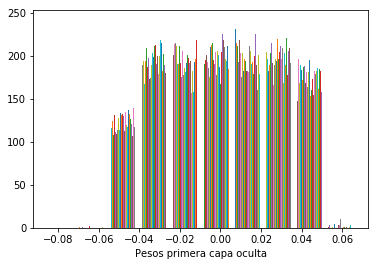

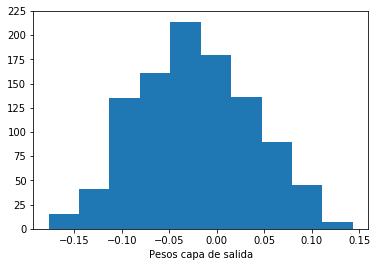

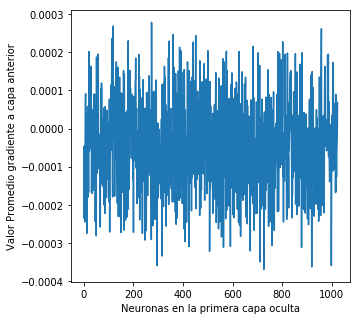

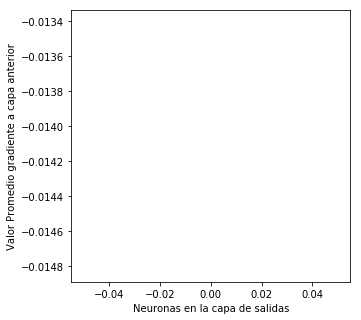

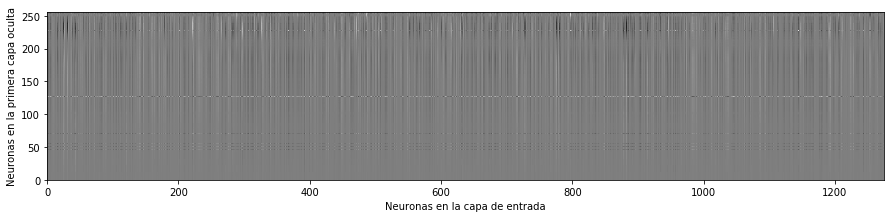

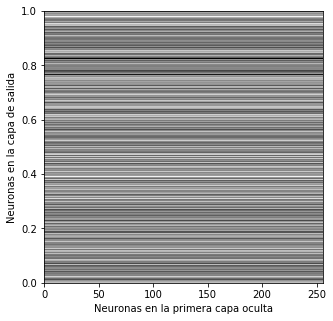

In [132]:
########################################## GRAFICADO DE PESOS
_= plt.hist(H2_weights0)
_= plt.xlabel('Pesos primera capa oculta')
plt.show()
_= plt.hist(H2_weights1)
_= plt.xlabel('Pesos capa de salida')
plt.show()

########################################## GRAFICADO DE GRADIENTES MEDIOS
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la primera capa oculta')
plt.plot(np.mean(H2_grafico0,axis=0));
_ = plt.figure(figsize=(5,5))
_ = plt.ylabel('Valor Promedio gradiente a capa anterior')
_ = plt.xlabel('Neuronas en la capa de salidas')
plt.plot(np.mean(H2_grafico1,axis=0));

########################################## GRAFICADO DE GRADIENTES
_ = plt.figure(figsize=(15,5))
_ = plt.xlabel('Neuronas en la capa de entrada')
_ = plt.ylabel('Neuronas en la primera capa oculta')
plt.imshow(H2_grafico0, interpolation='nearest', cmap=cm.Greys_r, extent=[0,1275,0,256])
_ = plt.figure(figsize=(5,5))
_ = plt.xlabel('Neuronas en la primera capa oculta')
_ = plt.ylabel('Neuronas en la capa de salida')
plt.imshow(H2_grafico1, interpolation='nearest', cmap=cm.Greys_r, extent=[0,256,0,1],aspect='auto')